# Introduction

The objective of this project is to predict the future trend of a time-series, in this special case the Bitcoin, cryptocurrency and global payment system created in 2009.
The project has been realized in Python with the use of the open source Jupyter Web application on a dataset obtained from the "Quandl" site.
In particular we will use mathematical concepts, including some studied in class, to modify this dataset and extract information and graphs.
Finally we will also perform a process of remodeling, aggregation, separation and transformation of data from a format to a more useful one to calculate results.

# Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) plays a critical role in understanding the what, why, and how of the problem statement. It’s first in the order of operations that a data analyst will perform when handed a new data source and problem statement.

Here’s a direct definition: exploratory data analysis is an approach to analyzing data sets by summarizing their main characteristics with visualizations. The EDA process is a crucial step prior to building a model in order to unravel various insights that later become important in developing a robust algorithmic model.

The main objective is to cover how to:
- Read and examine a dataset and classify variables by their type: quantitative vs. categorical
- Handle categorical variables with numerically coded values
- Perform univariate and bivariate analysis and derive meaningful insights about the dataset
- Identify and treat missing values and remove dataset outliers
- Build a correlation matrix to identify relevant variables

# Feature Engineering

Feature engineering, also known as "feature creation", is the process of constructing new features from existing data to train a machine learning model. 
Typically, feature engineering is a drawn-out manual process relying on domain knowledge, intuition, and data manipulation. Automated feature engineering aims to help the data scientist by automatically creating many candidate features out of a dataset from which the best can be selected and used for training.

Feature engineering efforts mainly have two goals:
- Preparing the proper input dataset, compatible with the machine learning algorithm requirements
- Improving the performance of machine learning models

# Jupyter Notebook Project

The first thing we'll do is import the required dependencies:

In [1]:
import quandl
import os
import plotly
import pickle
import seaborn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import time
import datetime

In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from matplotlib.pylab import rcParams
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from pandas import DataFrame
from plotly import tools

Using TensorFlow backend.


In [3]:
import plotly.plotly as py
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from mpl_finance import candlestick2_ohlc, volume_overlay
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
py.init_notebook_mode(connected=True)
plotly.offline.init_notebook_mode(connected=True)

In [4]:
from fbprophet import Prophet
from datetime import datetime as dt
from datetime import timedelta as td

We get Bitcoin price data using the __Quandl API__. To facilitate this data recovery we will define a function to download and cache Quandl datasets.

We use "pickle" to serialize and save the downloaded data as a file, thus preventing our script from downloading the same data again every time we run it. The function will return the data as a Pandas dataframe.

In [5]:
def get_quandl_data(quandl_id):
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

## Quandl

Designed for professional investors, __Quandl__ provides financial and economic data to over 400,000 users, including analysts from the best hedge funds and investment banks in the world. Quandl is the first and only alternative data market that offers investment professionals access to loopholes from the data economy and gives them an advantage in their search for profits.

The platform then provides the finished data product via APIs and tools familiar to modern investors.

In [6]:
data = quandl.get("BCHAIN/MKPRU", authtoken="CL4SbyNiw_NWebUiNoWA")

With info() we get a brief summary of the dataframe, useful when performing exploratory data analysis:

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3856 entries, 2009-01-03 to 2019-07-25
Data columns (total 1 columns):
Value    3856 non-null float64
dtypes: float64(1)
memory usage: 60.2 KB


With describe() we display some basic statistical details like percentile, mean, std ,etc...

In [8]:
data.describe()

,Value
count,3856.000000
mean,1570.326800
std,3009.277008
min,0.000000
25%,4.890575
50%,244.415000
75%,834.367500
max,19498.683333


We can inspect the first and last 10 rows of the dataframe using the head() and tail() functions:

In [9]:
data.head(10)

,Value
Date,
2009-01-03,0.0
2009-01-04,0.0
2009-01-05,0.0
2009-01-06,0.0
2009-01-07,0.0
2009-01-08,0.0
2009-01-09,0.0
2009-01-10,0.0
2009-01-11,0.0


In [10]:
data.tail(10)

,Value
Date,
2019-07-16,10438.554167
2019-07-17,10300.411667
2019-07-18,9584.475833
2019-07-19,10092.751667
2019-07-20,10455.730000
2019-07-21,10685.415000
2019-07-22,10569.305000
2019-07-23,10449.626667
2019-07-24,10044.113333


We generate a simple graph as a quick visual check that the data looks correct:

In [11]:
btc_trace = go.Scatter(x=data.index, y=data['Value'])

In [12]:
data = [btc_trace]
layout = dict(title = 'Bitcoin Price', xaxis = dict(title = 'Date'),
              yaxis = dict(title = 'Price, EUR'))
fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig)

## Pull Kraken BTC price exchange data

Kraken is a cryptocurrency exchange in which market participants can exchange various cryptocurrencies.
It is one of the most reliable exchanges ever, in fact until now it has never been breached.
__Kraken__ was founded in 2011 in San Francisco and officially started trading in 2013. It is owned by Payward Inc. and is led by CEO and co-founder Jesse Powell.

It provides the easy movement of money to and from the participant's linked bank accounts and the movement of encryptions to and from the participant's digital wallets from the trading accounts linked to Kraken.

The BTC price from Kraken is downloaded using the Quandl API:

_Daily Bitcoin exchange rate (BTC vs. EUR) on Kraken. Updated daily at 6:00 pm EST_

In [13]:
btc_eur_price_kraken = quandl.get("BCHARTS/KRAKENEUR", 
                                  start_date="2018-01-01", 
                                  authtoken="CL4SbyNiw_NWebUiNoWA")

*btc_eur_price_kraken_* is the daily-price found in the OHLC format. An OHLC chart is a type of chart typically used to illustrate the movements in the price of a financial instrument over time and indicate the open (*Open*), the maximum (*High*), the minimum (*Low*) and the close (*Close*).

Also in this case we are going to analyze the data from the dataframe.

In [14]:
btc_eur_price_kraken.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 570 entries, 2018-01-01 to 2019-07-24
Data columns (total 7 columns):
Open                 570 non-null float64
High                 570 non-null float64
Low                  570 non-null float64
Close                570 non-null float64
Volume (BTC)         570 non-null float64
Volume (Currency)    570 non-null float64
Weighted Price       570 non-null float64
dtypes: float64(7)
memory usage: 35.6 KB


In addition to *Open*, *High*, *Low* and *Close* we also find the *Volume* variable. The exchange volumes in technical analysis are used to indicate the number of transactions carried out in a specific period of time. They are very useful to understand how much a crypto is used and therefore also indicate the strength of the market behind the title.

### Weighted Price

Another variable is *Weighted Price*. In general a price-weighted index is an index in which the member companies are weighted in proportion to their price per share, rather than by number of shares outstanding, market capitalization or other factors. In a price-weighted index, stocks with higher prices receive a greater weight in the index, regardless of the issuing company's actual size or the number of shares outstanding. 

We consider the _Weighted Price_ because it is used as a trading benchmark by investors who aim to be as passive as possible in their execution, ensuring that the order is in line with the volume of the market.

In [15]:
btc_eur_price_kraken.describe()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
count,570.000000,570.000000,570.000000,570.000000,570.000000,5.700000e+02,570.000000
mean,6013.947193,6194.194386,5778.006140,5993.072281,6776.121441,4.322663e+07,5985.778057
std,2274.767467,2373.709952,2045.857168,2198.803099,5182.217469,4.012001e+07,2181.773080
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,4497.700000,4655.050000,4387.650000,4500.075000,3606.022351,1.665172e+07,4515.107245
50%,5674.800000,5775.100000,5570.700000,5669.400000,5347.479076,3.016573e+07,5661.488798
75%,7167.625000,7377.600000,6883.825000,7170.000000,8637.720812,5.687953e+07,7136.513867
max,20000.000000,20000.000000,13501.000000,14297.600000,51627.215385,2.814326e+08,13906.517090


In [16]:
btc_eur_price_kraken.head(10)

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2018-01-01,11993.6,11995.2,11090.0,11350.0,3683.187439,4.234853e+07,11497.794756
2018-01-02,11359.1,12746.0,10905.0,12299.8,6820.728096,8.050079e+07,11802.375574
2018-01-03,12299.8,12887.0,12290.0,12660.0,4919.664762,6.184691e+07,12571.365849
2018-01-04,12643.3,12819.2,12000.0,12750.4,5884.940852,7.314782e+07,12429.661599
2018-01-05,12750.4,14480.0,12412.1,14297.6,6933.182531,9.287741e+07,13396.071726
2018-01-06,14297.4,14333.8,13501.0,14184.0,4159.696979,5.784690e+07,13906.517090
2018-01-07,14184.0,14199.7,13039.8,13237.2,3916.302169,5.312791e+07,13565.835201
2018-01-08,13208.6,13287.3,11605.0,12648.7,6843.762924,8.558162e+07,12505.053923
2018-01-09,12635.1,12768.6,11961.8,12072.9,5723.383169,7.089031e+07,12386.084568


In [17]:
btc_eur_price_kraken.tail(10)

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2019-07-15,9471.0,9848.9,8800.0,9633.6,8828.289949,8.195404e+07,9283.115868
2019-07-16,9651.0,9808.7,8350.9,8404.0,11815.108681,1.061665e+08,8985.659733
2019-07-17,8421.1,8905.0,8102.2,8644.4,11292.260413,9.631642e+07,8529.419110
2019-07-18,8648.7,9611.5,8275.6,9445.0,10353.226911,9.314096e+07,8996.321682
2019-07-19,9445.0,9583.6,9040.0,9395.2,6053.787487,5.619114e+07,9281.981387
2019-07-20,9393.1,9900.0,9241.0,9607.5,4195.909244,4.014711e+07,9568.153822
2019-07-21,9607.4,9671.8,9212.5,9448.9,3198.080639,3.008653e+07,9407.682875
2019-07-22,9453.2,9536.5,8980.6,9228.9,5007.876852,4.629783e+07,9245.001909
2019-07-23,9220.8,9224.2,8812.0,8850.7,6155.880124,5.527081e+07,8978.539313


We generate a graph considering the _Weighted Price_ column:

In [18]:
btc_trace1 = go.Scatter(x=btc_eur_price_kraken.index, 
                       y=btc_eur_price_kraken['Weighted Price'])

In [19]:
data = [btc_trace1]
layout = dict(title = 'Weighted Price', xaxis = dict(title = 'Date'),
              yaxis = dict(title = 'Price, EUR'))
fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig)

We can see that there are irregularities certainly due to the failure to update the Quandl dataset.
We remove all the values 0, since we know that the price of Bitcoin has never been equal to 0 in the times we are examining.

In [20]:
btc_eur_price_kraken['Weighted Price'].replace(0, np.nan, inplace=True)
btc_eur_price_kraken['Weighted Price'].fillna(method='ffill', inplace=True)

When we plot again we will see a much cleaner graph without peaks.

In [21]:
btc_trace2 = go.Scatter(x=btc_eur_price_kraken.index, 
                       y=btc_eur_price_kraken['Weighted Price'])

In [22]:
data = [btc_trace2]
layout = dict(title = 'Weighted Price', xaxis = dict(title = 'Date'),
              yaxis = dict(title = 'Price, EUR'))
fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig)

A __correlation matrix__ is a table showing the value of the correlation coefficient between sets of variables (correlation coefficients are used in statistics to measure how strong a relationship is between two variables ).

This analysis allows you to see which pairs have the highest correlation, the pairs which are highly correlated represent the same variance of the dataset thus we can further analyze them to understand which attribute among the pairs are most significant for building the model. This plot shows you which variables are correlated to each other from a scale already predefined.

Below we find the correlation matrix of our initial dataset "btc_eur_price_kraken":

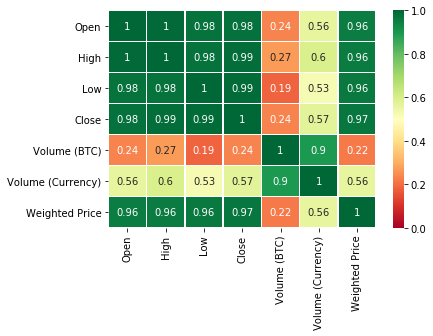

In [23]:
sns.heatmap(btc_eur_price_kraken.corr(), annot=True, 
            cmap='RdYlGn', linewidths=0.5, vmin=0)
plt.show()

From our correlation matrix we can understand that _Volume_ is correlated to _Weighted Price_. _Open_, _High_, _Low_ and _Close_ are directly related to _Weighted Price_.

Below is the code to plot the univariate distribution of the numerical columns which contains the histograms and the estimated PDF. We use displot of the seaborn library to plot this graph:

In [24]:
col_names = ['Open','High', 'Low', 'Close', 
             'Volume (BTC)', 'Volume (Currency)', 
             'Weighted Price']

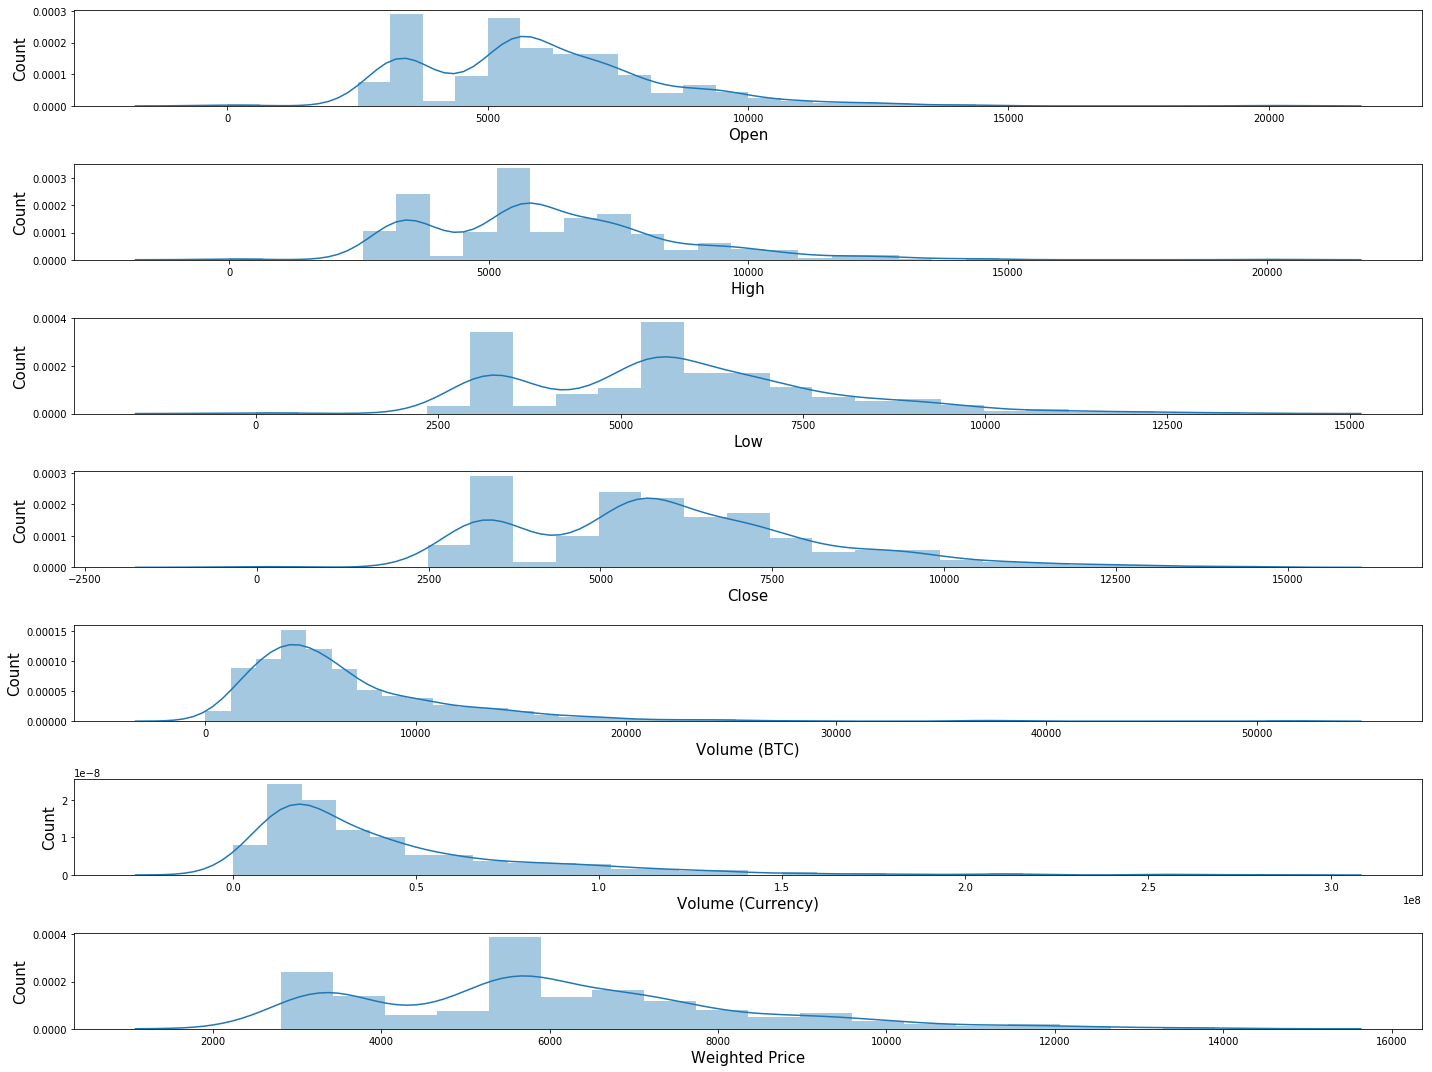

In [25]:
fig, ax = plt.subplots(len(col_names), figsize=(20,15))

for i, col_val in enumerate(col_names):

    sns.distplot(btc_eur_price_kraken[col_val], hist=True, ax=ax[i])
    ax[i].set_xlabel(col_val, fontsize=15)
    ax[i].set_ylabel('Count', fontsize=15)

fig.tight_layout()
plt.show()

An outlier might indicate a mistake in the data (like a typo, or a measuring error, seasonal effects etc), in which case it should be corrected or removed from the data before calculating summary statistics or deriving insights from the data, failing to which will lead to incorrect analysis.

Below is the code to plot the boxplot of all the column names mentioned in the list *col_names*.
A boxplot is a standardized way of displaying the distribution of data based on a five number summary:

- median (Q2/50th Percentile): the middle value of the dataset.

- first quartile (Q1/25th Percentile): the middle number between the smallest number (not the “minimum”) and the median of the dataset.

- third quartile (Q3/75th Percentile): the middle value between the median and the highest value (not the “maximum”) of the dataset.

- maximum: Q3 + 1.5*IQR

- minimum: Q1 - 1.5*IQR

IQR: 25th to the 75th percentile

<img src="boxplot.jpg" title="Boxplot" />
<figcaption><center>Figure 1 : Different parts of a boxplot</center></figcaption>

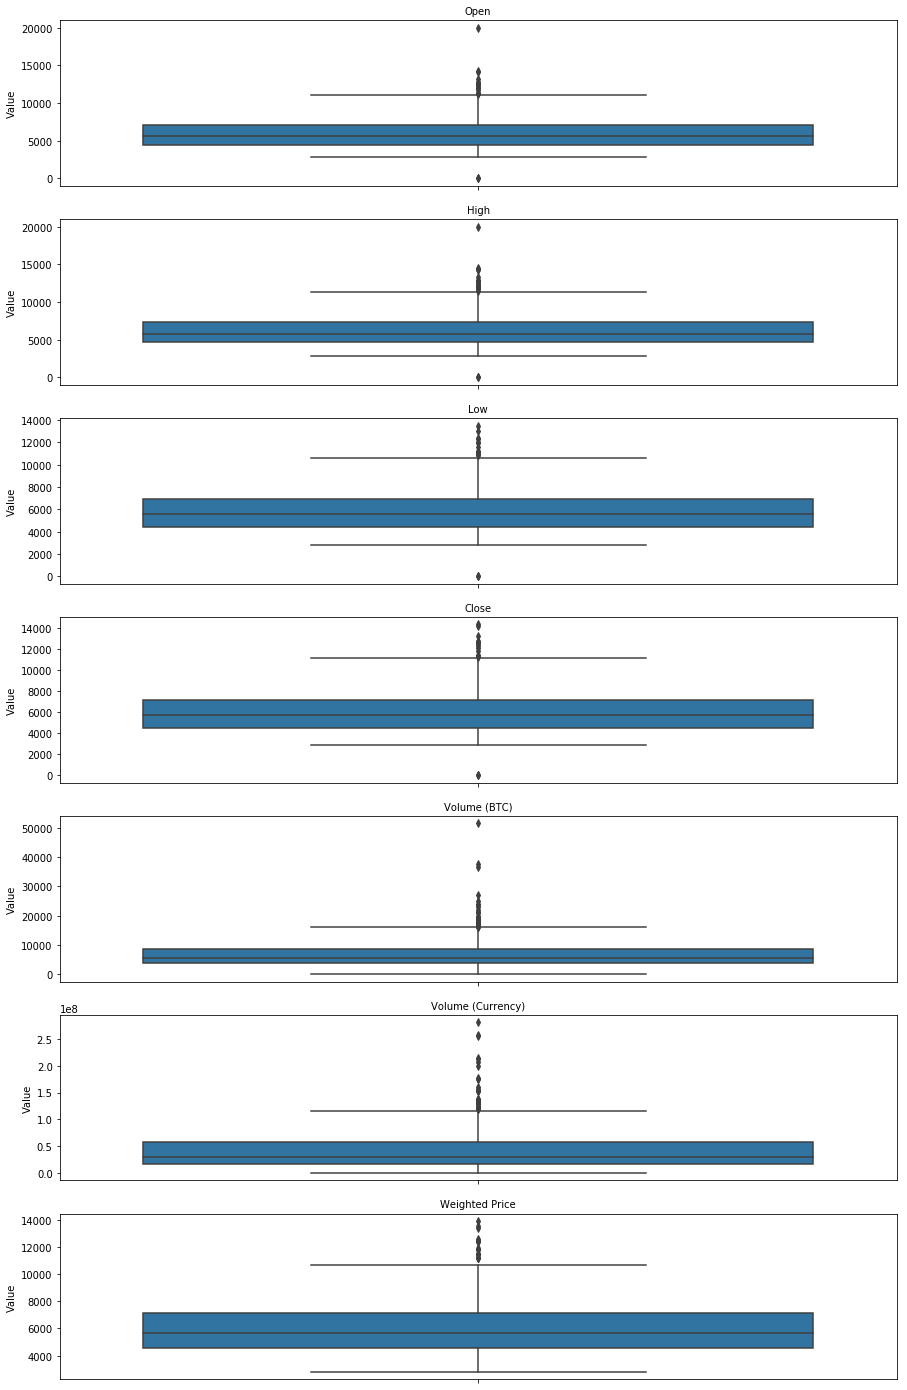

In [26]:
fig, ax = plt.subplots(len(col_names), figsize=(15,25))

for i, col_val in enumerate(col_names):

    sns.boxplot(y=btc_eur_price_kraken[col_val], ax=ax[i])
    
    ax[i].set_title(col_val, fontsize=10)
    ax[i].set_ylabel('Value', fontsize=10)

plt.show()

In our case the outliers are not due to "errors", they are simply "rare" values that BTC has assumed.
So they should not be removed, but to get an idea on how to delete these values, we will identify them using the __Interquartile Range Rule__ and then go and create a new dataset without an outlier.

In [27]:
df = pd.DataFrame(btc_eur_price_kraken, 
                 index = btc_eur_price_kraken.index, columns = col_names)

outlier_rang_max, outlier_rang_min = dict(), dict()

df_description = df.describe()
for col_name in col_names:
    q1 = df_description[col_name]['25%']
    q3 = df_description[col_name]['75%']
    iqr = q3-q1
    fence_low = q1-1.5*iqr
    outlier_rang_min[col_name] = fence_low
    fence_high = q3+1.5*iqr
    outlier_rang_max[col_name] = fence_high

def remove_outlier(df_in, col_names):
    q1 = df_in[col_names].quantile(0.25)
    q3 = df_in[col_names].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_names] > fence_low) 
                       & (df_in[col_names] < fence_high)]
    return df_out

filtered = df.apply(lambda x : x[(x.values > outlier_rang_min[x.name]) 
                                 & (x.values < outlier_rang_max[x.name])],
                    axis = 0)

Here is the number of outliers eliminated:

In [28]:
filtered.isna().sum()

Open                 17
High                 20
Low                  15
Close                16
Volume (BTC)         30
Volume (Currency)    31
Weighted Price       18
dtype: int64

We create a new dataset without outlier and let's trace the graph of the *Weighted Price* column.

In [29]:
new = filtered.copy()

In [30]:
btc_trace3 = go.Scatter(x=new.index, 
                        y=new['Weighted Price'])

In [31]:
data = [btc_trace3]
layout = dict(title = 'Weighted Price', xaxis = dict(title = 'Date'),
              yaxis = dict(title = 'Price, EUR'))
fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig)

**Candlestick Charts** are a type of financial chart for tracking the movement of securities. Candlesticks are so named because the rectangular shape and lines on either end resemble a candle with wicks.

Each candlestick represents one day’s worth of price data about a stock through four pieces of information: the opening price, the closing price, the high price, and the low price. The color of the central rectangle (called the real body) tells investors whether the opening price or the closing price was higher.

We plot our candlestick chart by taking the "Open", "High", "Low" and "Close" columns of our new dataset.

In [32]:
trace1 = go.Candlestick(x=new.index,
                open=new['Open'],
                high=new['High'],
                low=new['Low'],
                close=new['Close'],)                

In [33]:
data1 = [trace1]
layout = {
    'title': 'Candlestick',
    'yaxis': {'title': 'Price (EUR)'},
    'xaxis': {'title': 'Date'},
}
fig = dict(data=data1, layout=layout)
plotly.offline.iplot(fig, filename='candlestick')

## Pull pricing data for one more BTC exchange

The nature of Bitcoin exchanges is that the pricing is determined by supply and demand, hence no single exchange contains a true "master price" of Bitcoin. To solve this issue we will pull data from one more major Bitcoin exchange to calculate an aggregate Bitcoin price index.

Let's analyze now the *Weighted Price* data for one more BTC exchange and our dataset without outliers. The exchange in question is **Bitstamp** and we always find it on Quandl. Founded in 2011, Bitstamp is the world’s foremost Bitcoin exchange, providing customers with an easy to use, secure and reliable service.

We will download the data from each exchange into a dictionary of dataframes:

In [34]:
exchanges = ['BITSTAMP',]

exchange_data = {}
exchange_data['KRAKEN'] = btc_eur_price_kraken

for exchange in exchanges:
    exchange_code = 'BCHARTS/{}EUR'.format(exchange)
    btc_exchange_df = quandl.get("BCHARTS/BITSTAMPEUR",
                                 start_date="2018-01-01",
                                 authtoken="CL4SbyNiw_NWebUiNoWA")
    exchange_data[exchange] = btc_exchange_df
btc_exchange_df['Weighted Price'].replace(0, np.nan, inplace=True)
btc_exchange_df['Weighted Price'].fillna(method='ffill', inplace=True)

We will define a simple function to merge a common column of each dataframe into a new combined dataframe:

In [35]:
def merge_dfs_on_column(dataframes, labels, col):
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

Now we will merge all of the dataframes together on their _Weighted Price_ column.

In [36]:
btc_eur_datasets = merge_dfs_on_column(list(exchange_data.values()),
                                       list(exchange_data.keys()),
                                       'Weighted Price')

In [37]:
btc_eur_datasets.head(10)

,KRAKEN,BITSTAMP
Date,,
2018-01-01,11497.794756,NaN
2018-01-02,11802.375574,NaN
2018-01-03,12571.365849,NaN
2018-01-04,12429.661599,NaN
2018-01-05,13396.071726,NaN
2018-01-06,13906.517090,NaN
2018-01-07,13565.835201,NaN
2018-01-08,12505.053923,NaN
2018-01-09,12386.084568,NaN


Remark: these NaN values that we find above are due to the fact that the dataset on Bitstamp's Quandl is updated from February 14th 2018, as can be seen also from the graph that we find later.

In [38]:
btc_eur_datasets.tail(10)

,KRAKEN,BITSTAMP
Date,,
2019-07-15,9283.115868,9249.151153
2019-07-16,8985.659733,8961.383481
2019-07-17,8529.419110,8518.594049
2019-07-18,8996.321682,9041.362954
2019-07-19,9281.981387,9284.399048
2019-07-20,9568.153822,9584.360872
2019-07-21,9407.682875,9398.349381
2019-07-22,9245.001909,9225.778550
2019-07-23,8978.539313,8982.088444


The prices look to be as expected: they are in similar ranges, but with slight variations based on the supply and demand of each individual Bitcoin exchange.

The next logical step is to visualize how these pricing datasets compare. For this, we'll define a helper function to provide a single-line command to generate a graph from the dataframe:

In [39]:
def df_scatter(df, title, seperate_y_axis=False,
               y_axis_label='', scale='linear', initial_hide=False):
    label_arr = list(df)
    series_arr = list(map(lambda col: df[col], label_arr))
    
    layout = go.Layout(
        title=title,
        legend=dict(orientation="h"),
        xaxis=dict(type='date'),
        yaxis=dict(
            title=y_axis_label,
            showticklabels= not seperate_y_axis,
            type=scale
        )
    )
    
    y_axis_config = dict(
        overlaying='y',
        showticklabels=False,
        type=scale )
    
    visibility = 'visible'
    if initial_hide:
        visibility = 'legendonly'
        
# Form Trace For Each Series
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
            x=series.index, 
            y=series, 
            name=label_arr[index],
            visible=True
        )
        
# Add seperate axis for the series
        if seperate_y_axis:
            trace['yaxis'] = 'y{}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config    
        trace_arr.append(trace)

    fig = go.Figure(data=trace_arr, layout=layout)
    plotly.offline.iplot(fig)

We can now easily generate a graph for the Bitcoin pricing data:

In [40]:
df_scatter(btc_eur_datasets, 'Bitcoin Price (EUR) By Exchange')

We can now calculate a new column containing the average daily Bitcoin price across all of the exchanges.

In [41]:
btc_eur_datasets['avg_btc_price_eur'] = btc_eur_datasets.mean(axis=1)

In [42]:
btc_trace4 = go.Scatter(x=btc_eur_datasets.index,
                       y=btc_eur_datasets['avg_btc_price_eur'])

In [43]:
data = [btc_trace4]
layout = dict(title = 'Average Price', xaxis = dict(title = 'Date'),
              yaxis = dict(title = 'Price, EUR'))
fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig)

This new column is our Bitcoin pricing index.

Conclusions: In recent months we have witnessed an exponential growth of Bitcoins. From 1 January 2017 to 1 January 2018, Bitcoin had a percentage gain of 1418%. Bitcoin's historic high was $ 20089, reached near the arrival of CBOE futures (Chicago Board Option Exchange) and CME (Chicago Mercantile Exchange).

The commercial use of Bitcoin, and in general of cryptocurrencies, in the purchases of everyday life is profoundly influenced by volatility since the purchase of an asset, and therefore the passage of money, must guarantee a certain stability of value.

# Researching the model that will be best for the type of data

Our main goal is to train the best performing model possible, using the pre-processed data.

In Supervised learning, an AI system is presented with data which is labelled, which means that each data tagged with the correct label.
The supervised learning is categorized into 2 other categories which are “Classification” and “Regression”.

# Training and testing the model on data

In general for training a model we initially split the model into 3 three sections which are "Training data" ,"Validation data" and "Testing data".

- Training set: The training set is the material through which the computer learns how to process information. Machine learning uses algorithms to perform the training part. A set of data used for learning, that is to fit the parameters of the classifier.
- Validation set: Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. A set of unseen data is used from the training data to tune the parameters of a classifier.
- Test set: A set of unseen data used only to assess the performance of a fully-specified classifier.

Once the data is divided into the 3 given segments we can start the training process. In our case we only use train and test for LSTM and ARIMA models.

<img src="traintest.png" title="Train and Test model" />
<figcaption><center>Figure 2 : Train and Test model</center></figcaption>

# LSTM

Since we are using a time series dataset, it is not viable to use a feedforward-only neural network as tomorrow’s BTC price is most correlated with today’s, not a month ago’s.

A recurrent neural network (RNN) is a class of artificial neural network where connections between nodes form a directed graph along a sequence.
An RNN shows temporal dynamic behavior for a time sequence and it can use its internal state to process sequences.

Time series forecasting is quite different from other machine learning models because:
1. It is time dependent.
2. Along with an increasing or decreasing trend, most time series have some form of seasonality trends, i.e. variations specific to a particular time frame.

**Long Short Term Memory networks (LSTM)** are a special kind of RNN (Recurrent Neural Network) capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997) and were refined and popularized by many people in following work. They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior.

<img src="nn.png" title="History Price of Bitcoin" />
<figcaption><center>Figure 3 : Neural Network (NN)</center></figcaption>
<img src="rnn.jpeg" title="History Price of Bitcoin" />
<figcaption><center>Figure 4 : Recurrent Neural Network (RNN)</center></figcaption>

We begin to import our original dataset and defining it as _data_:

In [44]:
data = btc_eur_price_kraken

We Use MinMaxScaler, estimator scales and translates each feature individually such that it is in the given range on the training set to normalize _Weighted Price_ to range from $0$ to $1$:

In [45]:
values = data['Weighted Price'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

Data scaling or normalization is a process of making model data in a standard format so that the training is improved, accurate, and faster. The method of scaling data in neural networks is similar to data normalization in any machine learning problem.

A Machine Learning algorithm needs to be trained on a set of data to learn the relationships between different features and how these features affect the target variable. For this we need to divide the entire data set into two sets. One is the training set on which we are going to train our algorithm to build a model. The other is the testing set on which we will test our model to see how accurate its predictions are.

We want to predict the BTC price for three month, so we take the data of last 120 days as the test set.

In [46]:
prediction_days = 120
train= scaled[:len(scaled) - prediction_days]
test= scaled[len(scaled) - prediction_days:]
print(len(train), len(test))

450 120


In the next cell we define a function which creates _X_ inputs and _Y_ labels for our model. In the sequential forecasting, we predict the future value based on some previous and current values. So, our _Y_ label is the value from the next (future) point of time while the _X_ inputs are one or several values from the past.

The amount of these values we can set by tuning the parameter _look_back_ in our function. If we set it to _1_, this means that we predict current value _t_ based on the previous value _(t-1)_. The value _t_ corresponds to the current day.

In [47]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

We generate dataset for *trainX*, *trainY*, *testX*, *testY* and reshape *X* for model training to give a new shape without changing the data:

In [48]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

449
119


In [49]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Eventually, we can build and train our model.

The LSTM model that we are going to create will be a sequential model with multiple layers.

We imported the Sequential class from keras.models library and LSTM and Dense classes from keras.layers library.

The first parameter to the LSTM layer is the number of neurons or nodes that we want in the layer.

Dropout layer is added to avoid overfitting, which is a phenomenon where a machine learning model performs better on the training data compared to the test data.

To make our model more robust we add a dense layer at the end of the model. The number of neurons in the dense layer will be set to 1 since we want to predict a single value in the output.

We call the compile method on the Sequential model object which is "model" in our case. We use the mean squared error as loss function and to reduce the loss or to optimize the algorithm, we use the adam optimizer.

## Adam Algorithm

Adam is an optimization algorithm that can used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data.

The Adam optimization algorithm is a combination of the gradient descent with momentum algorithm and the RMS (Root Mean Square) Prop algorithm.

Adam is an optimization algorithm that can used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data.

The Adam optimization algorithm is a combination of the gradient descent with momentum algorithm and the RMS (Root Mean Square) Prop algorithm.

There are several advantages of the Adam Algorithm and some of them are listed below:

- Easy to implement
- Quite computationally efficient
- Requires little memory space
- Good for non-stationary objectives
- Works well on problems with noisy or sparse gradients
- Works well with large data sets and large parameters

Adam takes into account the moving average of the prime moments $m$ and the second $v$ of the gradient using the correct estimators $\hat{m}$ and $\hat{v}$ to contrast the bias towards *0* in the first iterations. Indicating the parameters with $w_{t}$ for the iteration $t$ and with $Q$ the cost function to optimize, we have:

$ m_{t+1}=\beta_{1}m_{t}+(1-\beta_{1})\nabla Q(w_{t}) $

$ v_{t+1}=\beta_{1}v_{t}+(1-\beta_{2})(\nabla Q(w_{t}))^2 $

$ \hat{m}=\frac{m_{t+1}}{1-\beta_{1}^{t+1}} $

$ \hat{v}=\frac{v_{t+1}}{1-\beta_{2}^{t+1}} $

$ w_{t+1}=w_{t}-\eta{\frac{\hat{m}}{{\sqrt{\hat{v}}}+\epsilon}} $

where $\epsilon$ is a smoothing term added for the purpose of numerical stability, $\beta_{1}$ and $\beta_{2}$ are hyperparameters that control exponential decay.

IMPORTANT: We keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted. We don't need to use a validation data set, it's a choice.

Now is the time to train the model that we defined in the previous few steps. To do so we call the fit method on the model and pass it our training features and labels as shown below:

In [50]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history = model.fit(trainX, trainY, 
                                epochs=1000, batch_size=200, 
                                validation_data=(testX, testY), 
                                verbose=0, shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


We have trained our model.

On the plot below we compare the Train and Test loss on each iteration of the training process. We can see, that after some iterations the train and test loss became very similar, which is a good sign (this means we are not overfitting the train set).

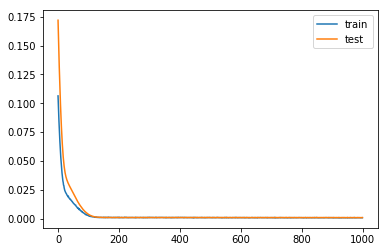

In [51]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

We make prediction using *textX* and plotting line graph against *testY*.

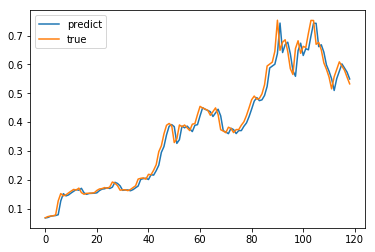

In [52]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

We scaler Inverse *Y* back to normal value:

In [53]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

Evaluating the model accuracy is an essential part of the process in creating machine learning models to describe how well the model is performing in its predictions.

We calculate the MSE, MAE and RMSE metrics, mainly used to evaluate the prediction error rates and model performance in regression analysis:

- __MAE (Mean Absolute Error)__ : represents the difference between the original and predicted values extracted by averaged the absolute difference over the data set

- __MSE (Mean Squared Error)__ : represents the difference between the original and predicted values extracted by squared the average difference over the data set

- __RMSE (Root Mean Squared Error)__ : is the error rate by the square root of MSE

RMSE is an intuitive estimator of the quality of the model.

In [54]:
mae = mean_absolute_error(testY_inverse, yhat_inverse)
print('MAE: %.3f' % mae)
mse = mean_squared_error(testY_inverse, yhat_inverse)
print('MSE: %.3f' % mse)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

MAE: 216.158
MSE: 102328.570
RMSE: 319.888


We plot line graph with _Y_ as _EUR_.

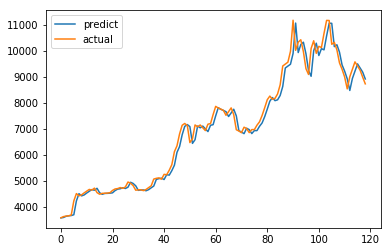

In [55]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual')
pyplot.legend()
pyplot.show()

We convert _X_ to dates and reshape _testY_ and _yhat_ for plotly.

In [56]:
predictDates = data.tail(len(testX)).index

In [57]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

We plot predicted and actual line graph with _X=dates_, _Y=EUR_:

In [58]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
plotly.offline.iplot([predict_chart, actual_chart])

Let’s calculate a symmetric mean absolute percentage error (SMAPE). It will show how good our predictions are in percentage. We define function *symmetric_mean_absolute_percentage_error* which will perform all necessary calculations:

$SMAPE=\frac {100\%}{n}\sum_{t=1}^{n}{\frac{\left|F_{t}-A_{t}\right|}{(|A_{t}|+|F_{t}|)/2}}$

where $F_t$ is the forecast value and $A_t$ is the actual value.

In [59]:
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred))/2)) * 100

SMAPE = symmetric_mean_absolute_percentage_error(testY_inverse, yhat_inverse)

print('Test SMAPE (percentage): %.3f' % SMAPE)

Test SMAPE (percentage): 2.836


## Using additional features for model training

As we have seen before in the correlation matrix of our original dataset, _Volume_ is correlated to _Weighted Price_. Let's go and work on this data.

Machine learning methods like deep learning can be used for time series forecasting. Before machine learning can be used, time series forecasting problems must be re-framed as supervised learning problems from a sequence to pairs of input and output.

A key function to help transform time series data into a supervised learning problem is the Pandas *shift()* function.

Given a DataFrame, the *shift()* function can be used to create copies of columns that are pushed forward (rows of NaN values added to the front) or pulled back (rows of NaN values added to the end).

We define a function named *series_to_supervised()* that takes a univariate or multivariate time series and frames it as a supervised learning dataset.

The function takes four arguments:

- data: Sequence of observations as a list or 2D NumPy array (Required).
- n_in: Number of lag observations as input (X). Values may be between *[1..len(data)]* (Optional, defaults to 1).
- n_out: Number of observations as output (y). Values may be between *[0..len(data)-1]* (Optional, defaults to 1).
- dropnan: Boolean whether or not to drop rows with NaN values (Optional, defaults to True).

The function returns a single value:

- return: Pandas DataFrame of series framed for supervised learning.

The function to convert the series into supervised learning is this:

In [60]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
# input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

We Get all data values, normalize features to range from $0$ to $1$ and frame as supervised learning.

In [61]:
values = data[['Weighted Price'] 
              + ['Volume (BTC)'] + ['Volume (Currency)']].values
values = values.astype('float32')

In [62]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [63]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
1,0.782892,0.071342,0.150475,0.810345,0.132115,0.286039
2,0.810345,0.132115,0.286039,0.879658,0.095292,0.219757
3,0.879658,0.095292,0.219757,0.866885,0.113989,0.259912
4,0.866885,0.113989,0.259912,0.953992,0.134293,0.330017
5,0.953992,0.134293,0.330017,1.000000,0.080572,0.205544


We drop unnecessary columns and split again data for training and testing.

In [64]:
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.782892   0.071342   0.150475  0.810345
2   0.810345   0.132115   0.286039  0.879658
3   0.879658   0.095292   0.219757  0.866885
4   0.866885   0.113989   0.259912  0.953992
5   0.953992   0.134293   0.330017  1.000000


In [65]:
values = reframed.values
n_train = 120
train= values[:len(values) - n_train]
test= values[len(values) - n_train:]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(449, 1, 3) (449,) (120, 1, 3) (120,)


In [66]:
multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dropout(0.2))
multi_model.add(Dense(1))
multi_model.compile(loss='mse', optimizer='adam')
multi_history = multi_model.fit(train_X, train_y, 
                                epochs=1000, batch_size=200, 
                                validation_data=(test_X, test_y), 
                                verbose=0, shuffle=False)

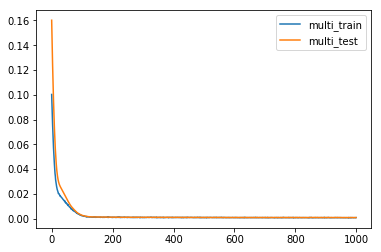

In [67]:
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

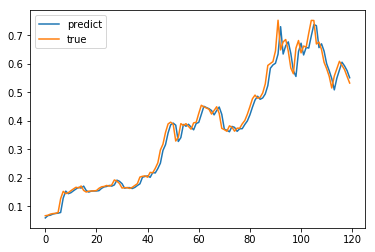

In [68]:
yhat = multi_model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

In [69]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

The MAE, MSE and RMSE are:

In [70]:
mae = mean_absolute_error(inv_y, inv_yhat)
print('MAE: %.3f' % mae)
mse = mean_squared_error(inv_y, inv_yhat)
print('MSE: %.3f' % mse)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

MAE: 214.331
MSE: 98981.773
RMSE: 314.614


We plot line graph with actual price, predicted price with feature _Weighted Price_ and predicted price with features _Volume_ and _Weighted Price_.

In [71]:
actual_chart = go.Scatter(x=predictDates, 
                          y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, 
                                 y=inv_yhat, name= 'Multi Predict Price')
predict_chart = go.Scatter(x=predictDates, 
                           y=yhat_reshape, name= 'Predict Price')
plotly.offline.iplot([predict_chart, multi_predict_chart, actual_chart])

The symmetric mean absolute percentage error (SMAPE) is:

In [72]:
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred))/2)) * 100

SMAPE = symmetric_mean_absolute_percentage_error(inv_y, inv_yhat)

print('Test SMAPE (percentage): %.3f' % SMAPE)

Test SMAPE (percentage): 2.819


# ARIMA 

A time series is a sequence where a metric is recorded over regular time intervals. Forecasting a time series (like demand and sales) is often of tremendous commercial value.

A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time. But why is it important? Most of the TS models work on the assumption that the TS is stationary.

We can check stationarity using the following:

1. __Plotting Rolling Statistics__: Plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant _t_, we’ll take the average/variance of the last year, i.e. last 12 months (this is a visual technique)

2. __Dickey-Fuller Test__: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the time series is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the "Test Statistic" is less than the "Critical Value", we can reject the null hypothesis and say that the series is stationary. Statistical tests make strong assumptions about your data

_Null Hypothesis (H0)_: If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

_Alternate Hypothesis (H1)_: The null hypothesis is rejected, it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure. We interpret this result using the p-value from the test.

A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we accept the null hypothesis (non-stationary).

- _p-value > 0.05_: Accept the null hypothesis _(H0)_, the data has a unit root and is non-stationary.

- _p-value <= 0.05_: Reject the null hypothesis _(H0)_, the data does not have a unit root and is stationary.

__ARIMA__ model is implemented to compare its predictability with the LSTM and figure out which is the most suitable method for time series data which has huge fluctuations.

An ARIMA model is a class of statistical models for analyzing and forecasting time series data. It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration. This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

- __AR__: Autoregression: A model that uses the dependent relationship between an observation and some number of lagged observations
- __I__: Integrated: The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary
- __MA__: Moving Average: A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations

A standard notation is used of ARIMA (p, d, q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

- __p__: The number of lag observations included in the model, also called the lag order
- __d__: The number of times that the raw observations are differenced, also called the "degree of differencing"
- __q__: The size of the moving average window, also called the order of moving average

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

An importance concern here is how to determine the value of 'p' and 'q'. We use two plots to determine these numbers:

- __Autocorrelation Function (ACF)__: It is a measure of the correlation between the the TS with a lagged version of itself

- __Partial Autocorrelation Function (PACF)__: This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons

We import the required dependencies taking the _Weighted Price_ data:

In [73]:
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller

In [74]:
ts = data['Weighted Price']

As we have said before,, the first important thing when forecasting time series is to check if the data is stationary. This means that our data is influenced by such factors as trend or seasonality.

The seasonal component, given a "period", is the value of the measurement under examination that is repeated the same for each period.

The trend component, using the moving averages, is the one that identifies the macroscopic trend of the series.
In simple terms, the trend shows whether compared to the seasonal trend, the value of the measurement under examination is further rising or falling.

The residual component is the noise which, as can be guessed, corresponds to what remains of the value under examination by subtracting the two previous components.

We can see also the actual price movements (“observed”).

In [75]:
s = sm.tsa.seasonal_decompose(btc_eur_price_kraken['Weighted Price'].values, freq=60)

In [76]:
trace1 = go.Scatter(x = np.arange(0, len(s.trend), 1),
                    y = s.trend,mode = 'lines',name = 'Trend',
    line = dict(color = ('rgb(244, 146, 65)'), width = 4))
trace2 = go.Scatter(x = np.arange(0, len(s.seasonal), 1),
                    y = s.seasonal,mode = 'lines',name = 'Seasonal',
    line = dict(color = ('rgb(66, 244, 155)'), width = 2))

trace3 = go.Scatter(x = np.arange(0, len(s.resid), 1),
                    y = s.resid,mode = 'lines',name = 'Residual',
    line = dict(color = ('rgb(209, 244, 66)'), width = 2))

trace4 = go.Scatter(x = np.arange(0, len(s.observed), 1),
                    y = s.observed,mode = 'lines',name = 'Observed',
    line = dict(color = ('rgb(66, 134, 244)'), width = 2))

data = [trace1, trace2, trace3, trace4]
layout = dict(title = 'Seasonal decomposition', xaxis = dict(title = 'Time'),
              yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig, filename='seasonal_decomposition')

Most business and economic time series are far from stationary when expressed in their original units of measurement, and even after diminution or seasonal adjustment they will typically still exhibit trends, cycles, random-walking, and other non-stationary behavior.   If the series has a stable long-run trend and tends to revert to the trend line following a disturbance, it may be possible to stationarize it by de-trending (e.g. including the time index as an independent variable in a regression or ARIMA model). Such a series is said to be trend-stationary.

However, sometimes even de-trending is not sufficient to make the series stationary, in which case it may be necessary to transform it into a series of period-to-period and/or season-to-season differences.  If the mean, variance, and autocorrelations of the original series are not constant in time, even after detrending, perhaps the statistics of the changes in the series between periods or between seasons will be constant. Such a series is said to be difference-stationary.

The next thing we do is the examination of the autocorrelation. It is the similarity between observations as a function of the time lag between them. It is important for finding repeating patterns in the data.

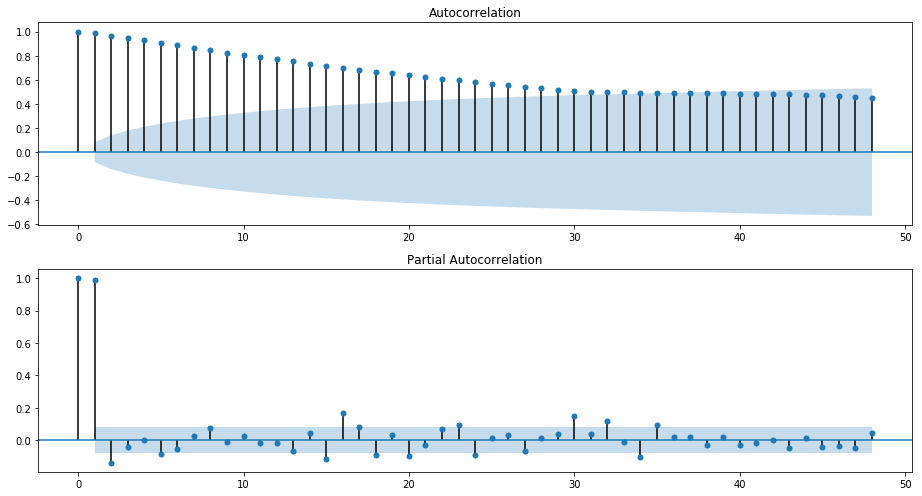

In [77]:
plt.figure(figsize=(13,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(btc_eur_price_kraken['Weighted Price'].values.squeeze(),
                         lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(btc_eur_price_kraken['Weighted Price'].values.squeeze(),
                          lags=48, ax=ax)
plt.tight_layout()
plt.show()

In this plot, the two dotted lines on either sides of 0 are the confidence intervals. These can be used to determine the $p$ and $q$ values, parameters of the ARIMA model.

We Determine rolling statistics and Perform Dickey-Fuller test.

In [78]:
def test_stationarity(timeseries):
    
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
    index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

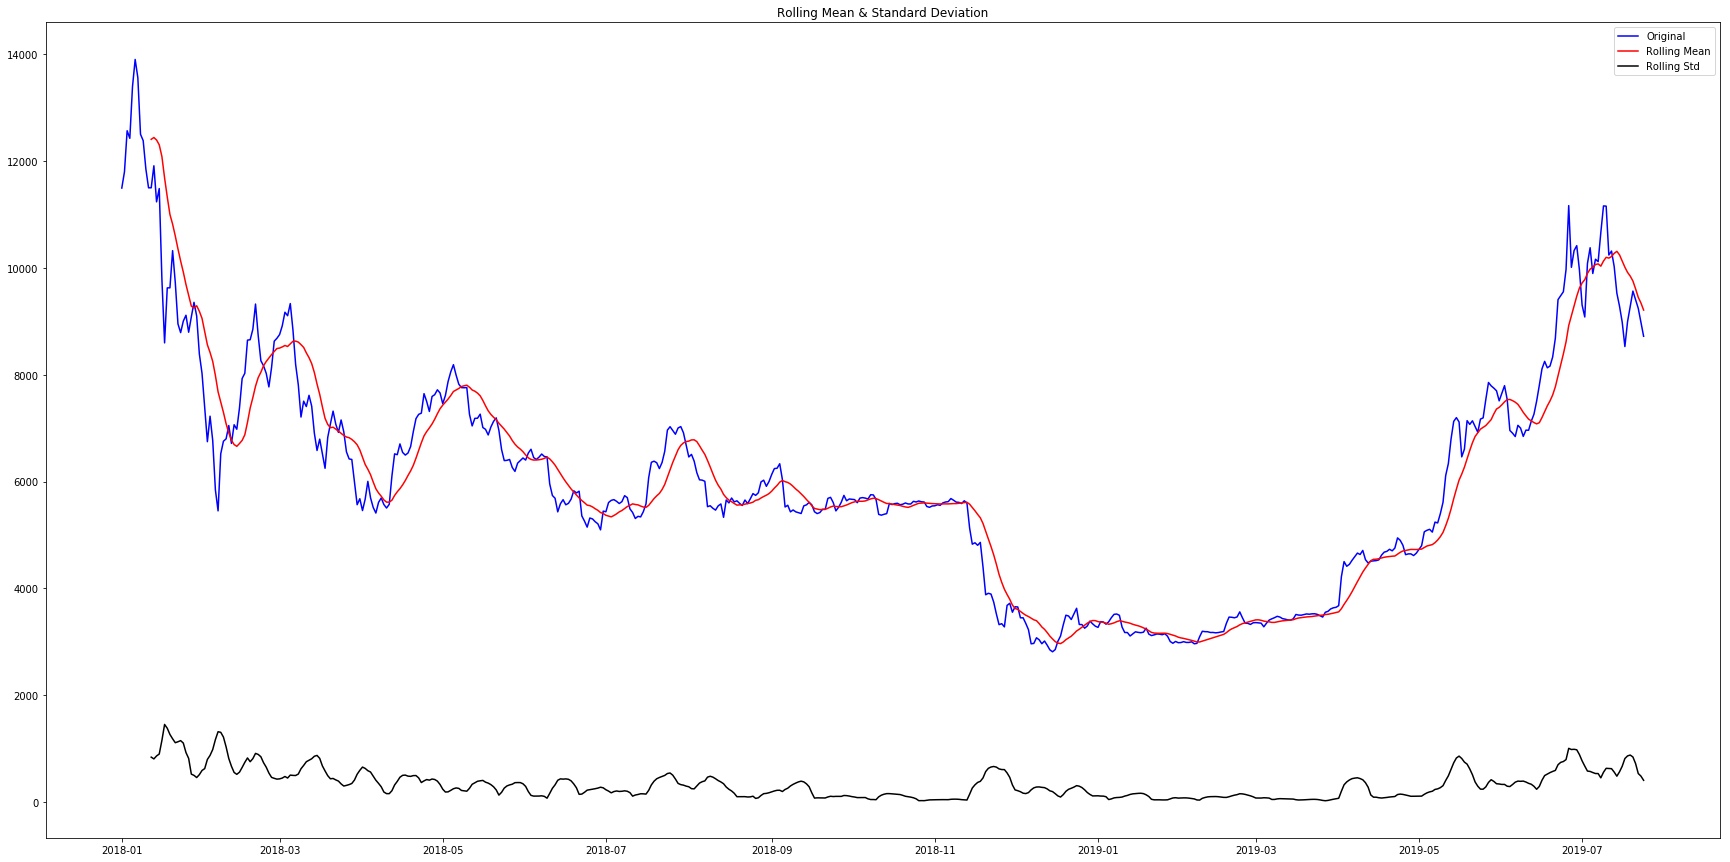

Results of Dickey-Fuller Test:
Test Statistic                  -2.063489
p-value                          0.259447
#Lags Used                      17.000000
Number of Observations Used    552.000000
Critical Value (1%)             -3.442252
Critical Value (5%)             -2.866790
Critical Value (10%)            -2.569566
dtype: float64


In [79]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
rcParams['figure.figsize'] = 30, 15
test_stationarity(ts)

The series isn't stationary. There are two major reasons behind non-stationarity of a TS:

1. Trend: varying mean over time
2. Seasonality: variations at specific time-frames

There are two ways of removing trend and seasonality:

- Differencing: taking the differece with a particular time lag
- Decomposition: modeling both trend and seasonality and removing them from the model.

One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity.

Log transformation is used to unskew highly skewed data, thus helping in forecasting process.

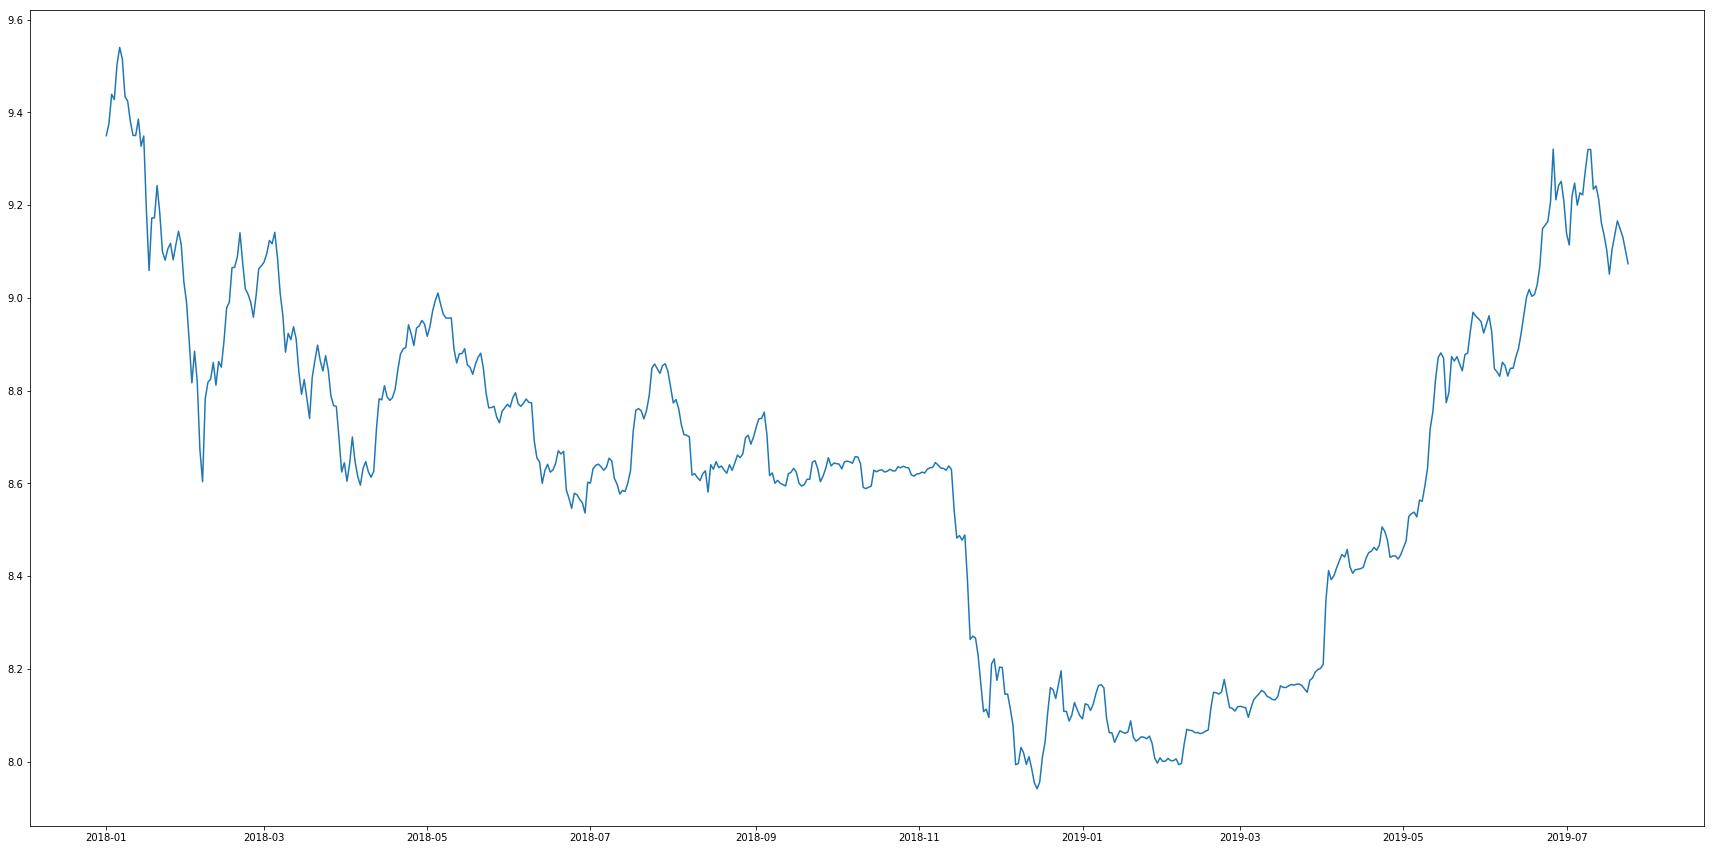

In [80]:
ts_log = np.log(ts)
plt.plot(ts_log)
plt.show()

First order differencing can be done in Pandas as:

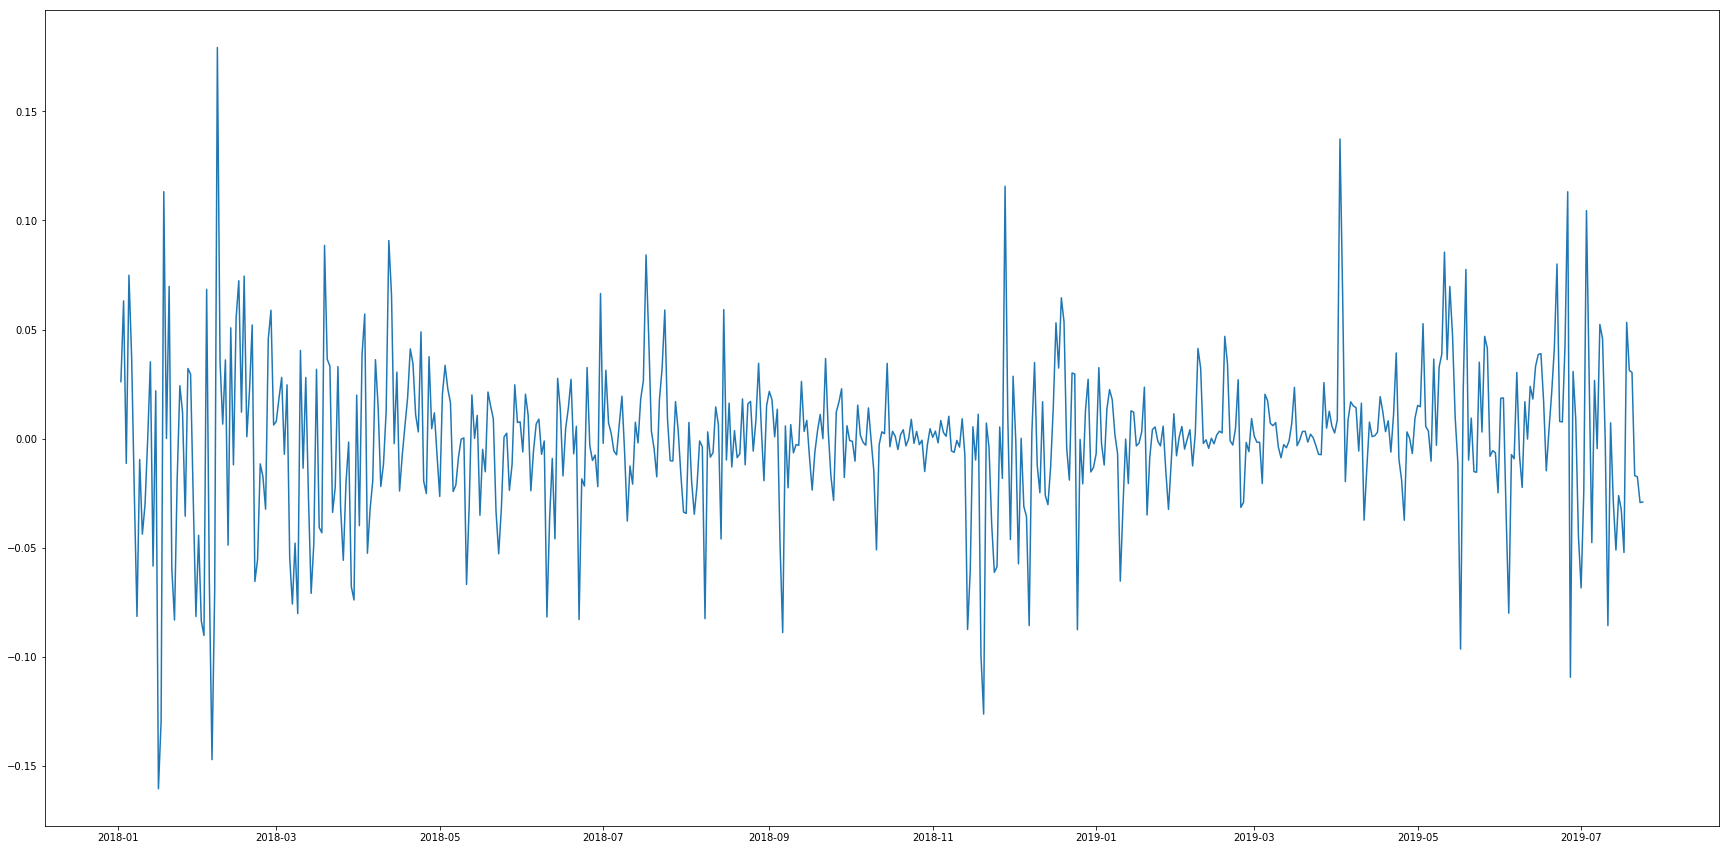

In [81]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
plt.show()

This appears to have reduced trend considerably. Let's verify using our plots:

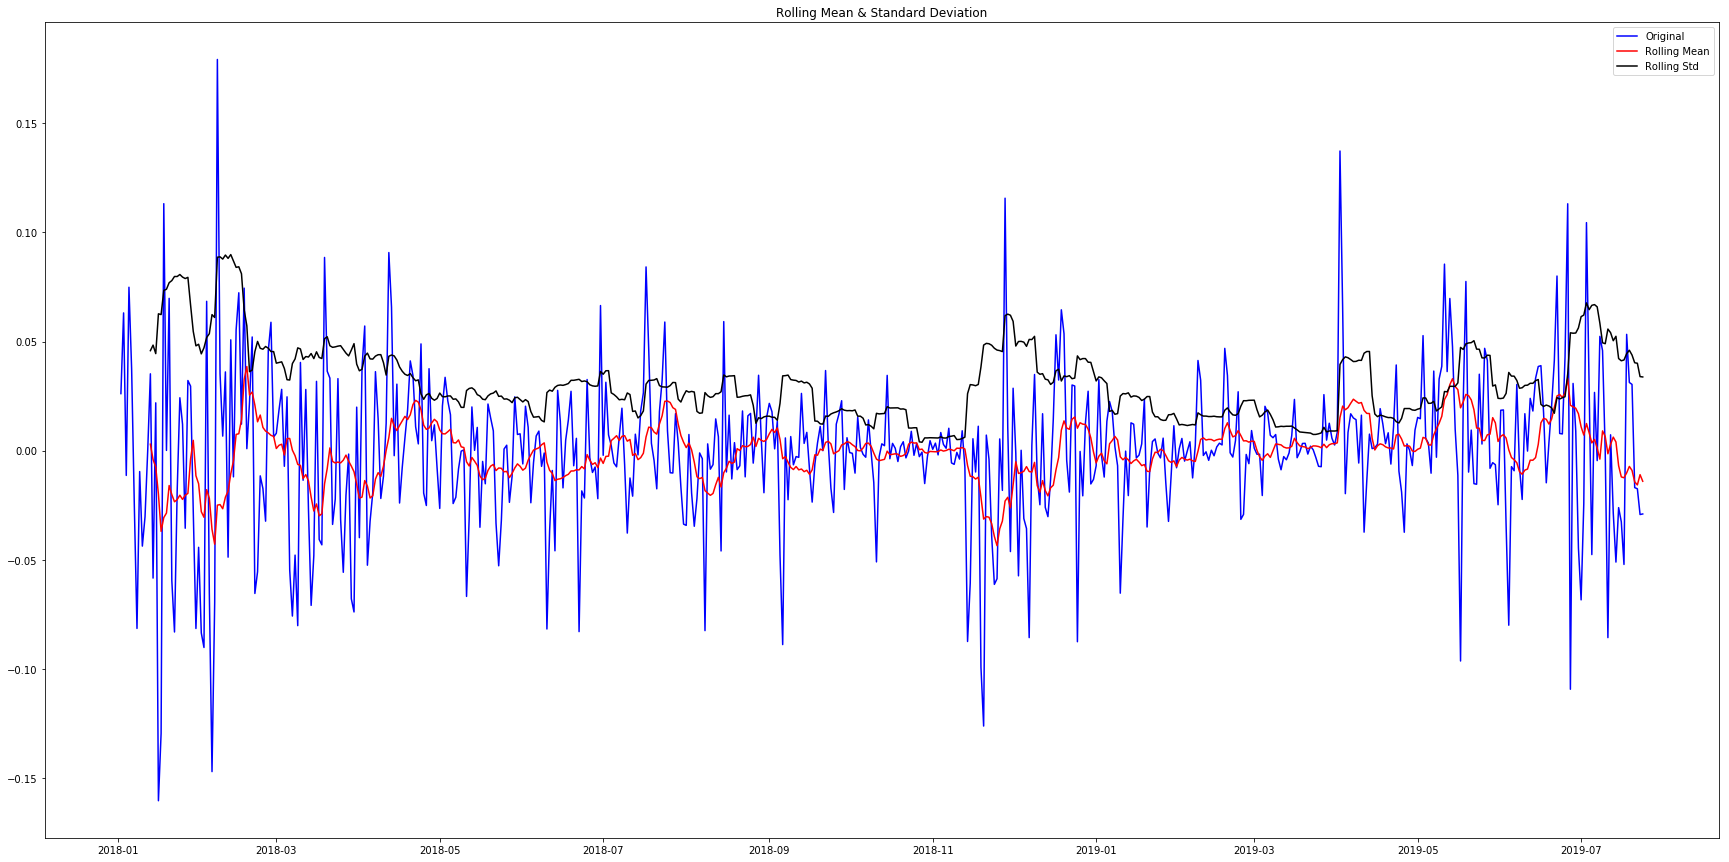

Results of Dickey-Fuller Test:
Test Statistic                -1.279818e+01
p-value                        6.844093e-24
#Lags Used                     2.000000e+00
Number of Observations Used    5.660000e+02
Critical Value (1%)           -3.441956e+00
Critical Value (5%)           -2.866660e+00
Critical Value (10%)          -2.569497e+00
dtype: float64


In [82]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

Now the current time series is stationary.

The ACF and PACF plots for the TS after differencing can be plotted as:

In [83]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

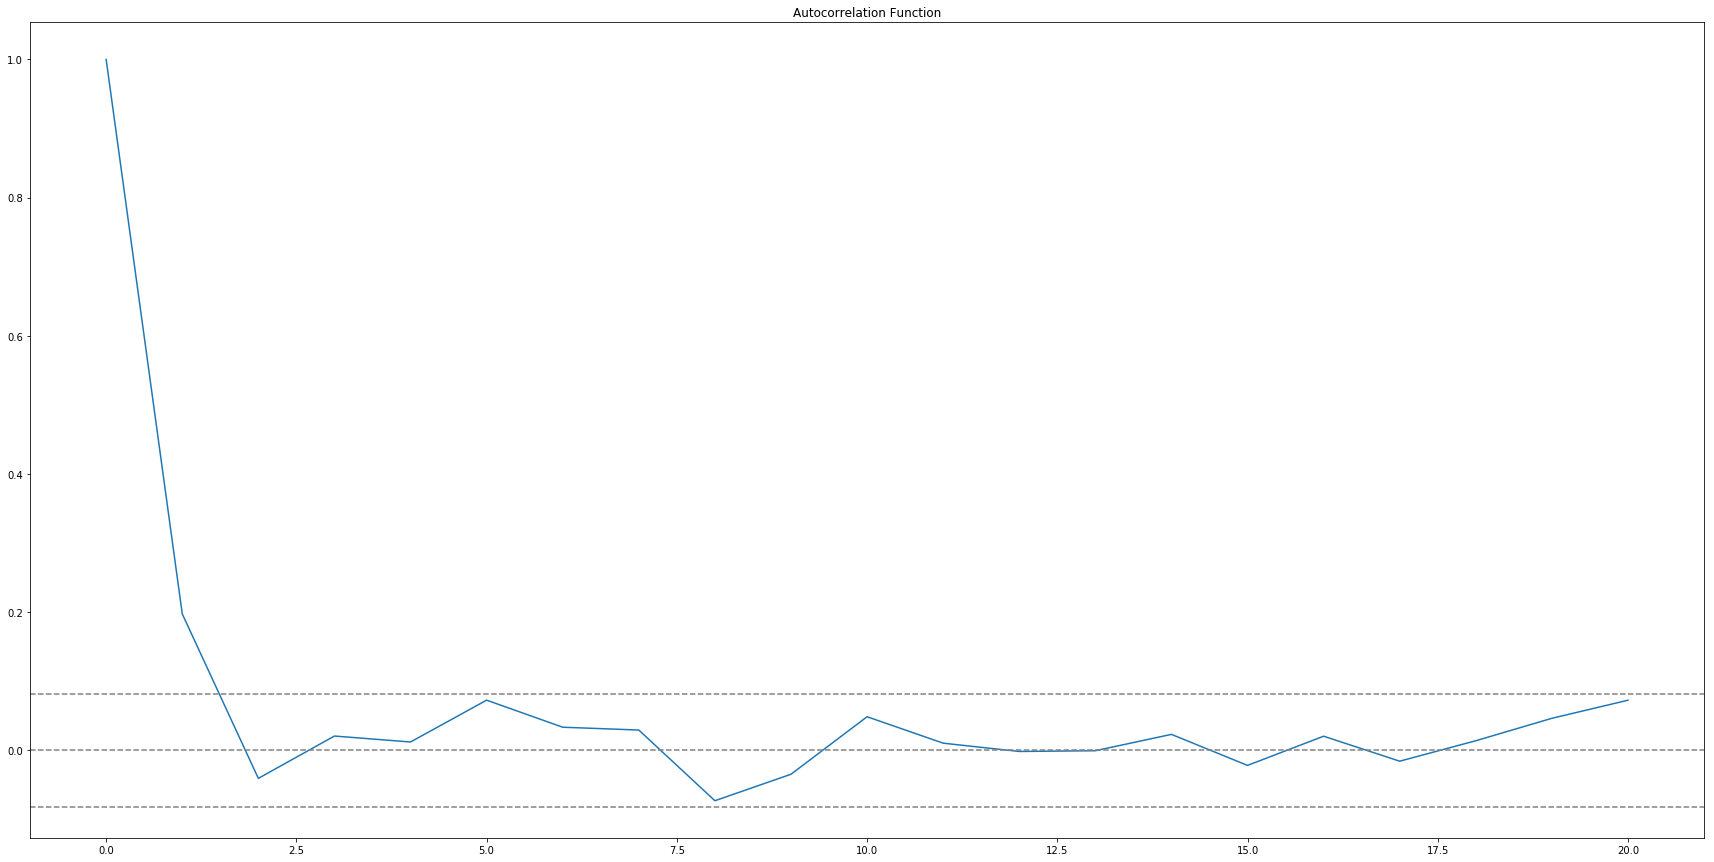

In [84]:
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()

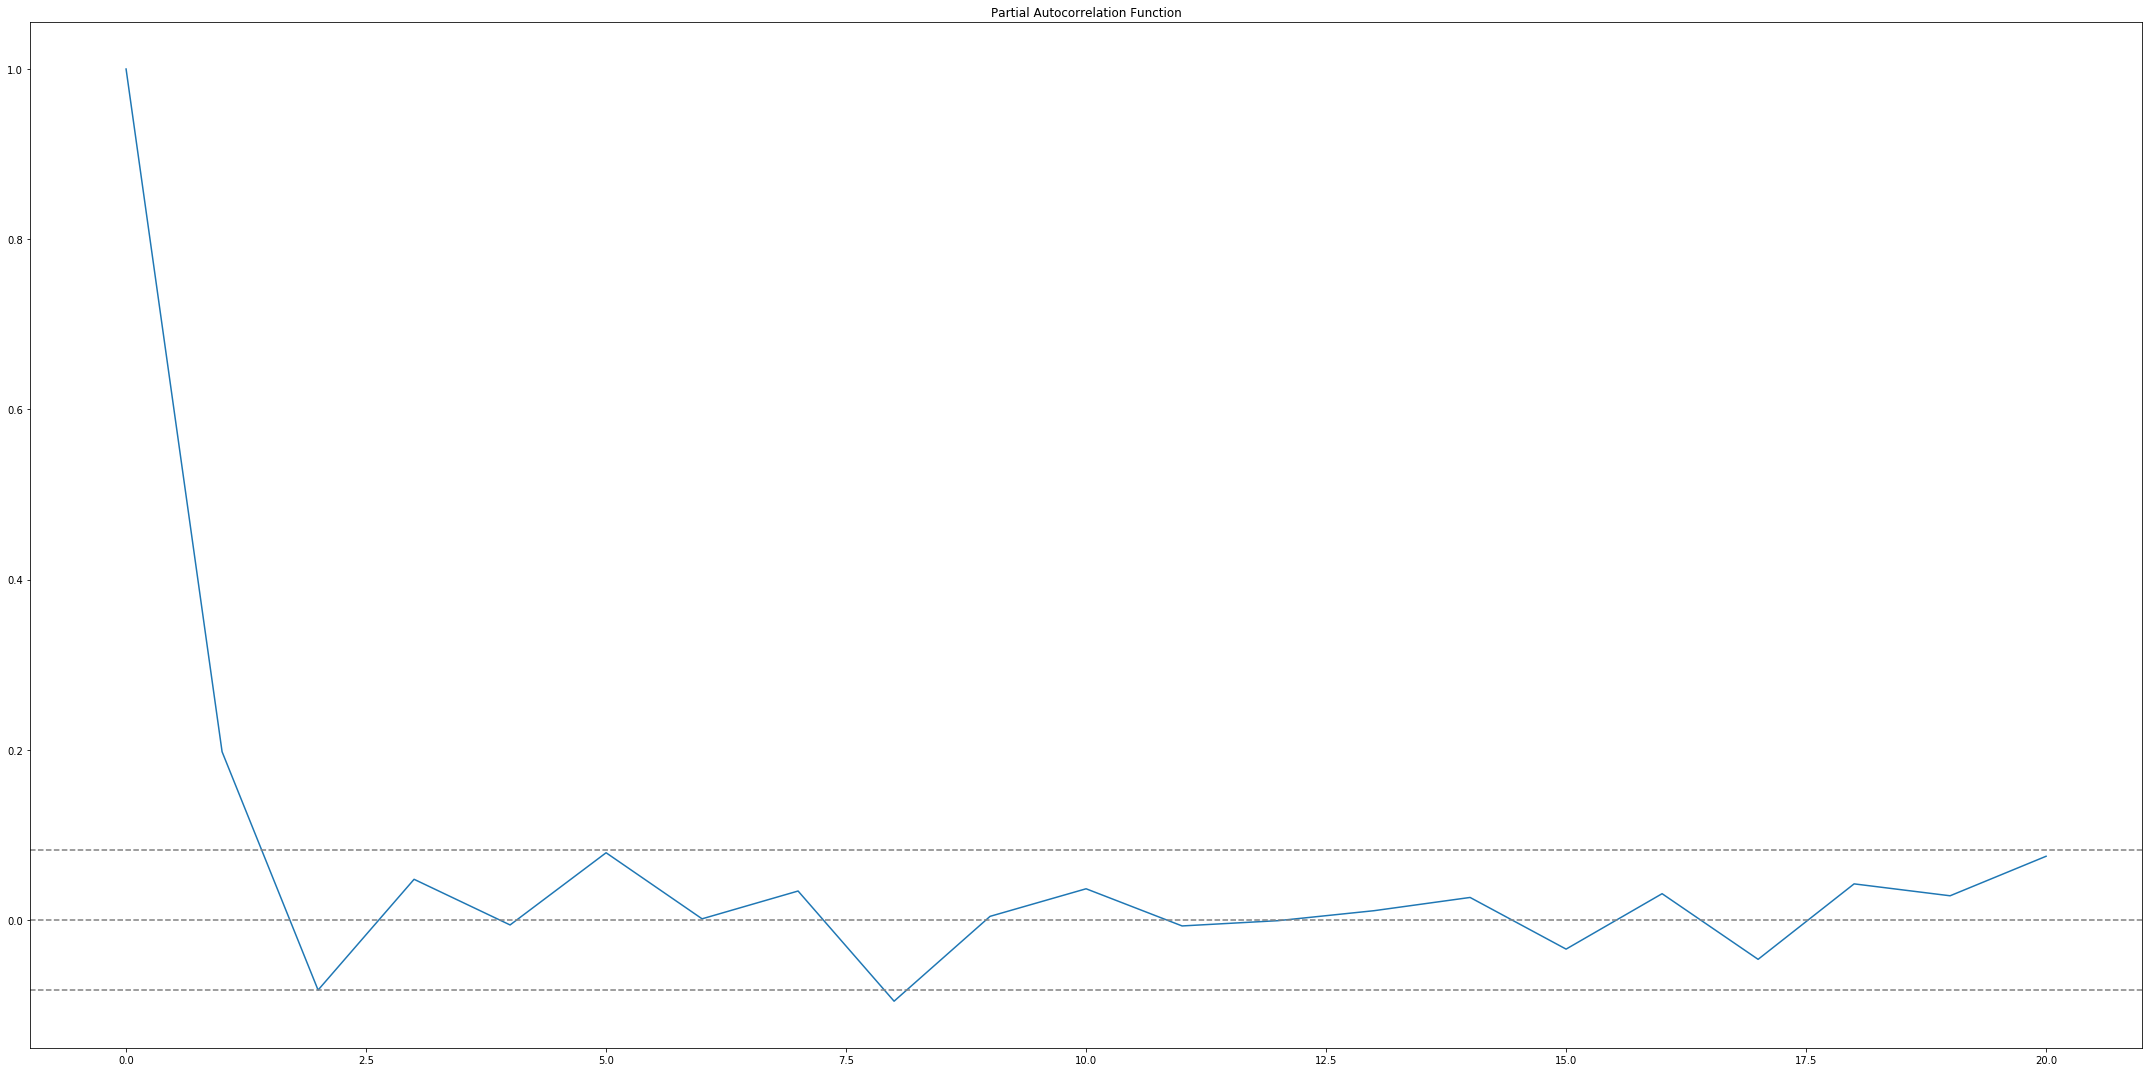

In [85]:
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

In this plot, the two dotted lines on either sides of 0 are the confidence intervals. These can be used to determine the ‘p’ and ‘q’ values as:

_p_: The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2

_q_: The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2

Now let's predict the last value in the data (Train and Test) with the values p, d and q, the last value in the data and for the next 5 days.

## Predicting the last value in the data (Train and Test)

In [86]:
X = ts.values

train_size = int(len(X) * 0.7)
train, test = X[0:train_size], X[train_size:]

model = ARIMA(train, order=(2,1,2))
model_fit = model.fit(disp=False)
forecast, stderr, conf = model_fit.forecast()
print('Expected: %.3f' % test[0])
print('Forecast: %.3f' % forecast)
print('Standard Error: %.3f' % stderr)
print('95%% Confidence Interval: %.3f to %.3f' % (conf[0][0], conf[0][1]))

Expected: 2986.878
Forecast: 2958.327
Standard Error: 259.052
95% Confidence Interval: 2450.593 to 3466.060


Confidence level determines the band in which we can safely say the predicted and actual values can lie.

We also calculate the MAE, MSE and RMSE.

In [87]:
mae = mean_absolute_error(test.shape, forecast.shape)
print('MAE: %.3f' % mae)
mse = mean_squared_error(test.shape, forecast.shape)
print('MSE: %.3f' % mse)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

MAE: 170.000
MSE: 28900.000
RMSE: 170.000


In [88]:
X = ts.values

train_size = int(len(X) * 0.7)
train, test = X[0:train_size], X[train_size:]

model = ARIMA(train, order=(2,1,2))
model_fit = model.fit(disp=False)
intervals = [0.2, 0.1, 0.05, 0.01]
for a in intervals:
    forecast, stderr, conf = model_fit.forecast(alpha=a)
    print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, 
    forecast, conf[0][0], conf[0][1]))

80.0% Confidence Interval: 2958.327 between 2626.338 and 3290.315
90.0% Confidence Interval: 2958.327 between 2532.223 and 3384.430
95.0% Confidence Interval: 2958.327 between 2450.593 and 3466.060
99.0% Confidence Interval: 2958.327 between 2291.052 and 3625.601


Now we predict the last value and predictions for the next 5 days.

## Predicting the last value in the data

In [89]:
X = ts.values
size = len(X) - 1
train, test = X[0:size], X[size:]
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit(disp=False)
forecast, stderr, conf = model_fit.forecast()
print('Expected: %.3f' % test)
print('Forecast: %.3f' % forecast)
print('Standard Error: %.3f' % stderr)
print('95%% Confidence Interval: %.3f to %.3f' % (conf[0][0], conf[0][1]))

Expected: 8722.053
Forecast: 8915.796
Standard Error: 261.684
95% Confidence Interval: 8402.904 to 9428.688


In [90]:
mae = mean_absolute_error(test, forecast)
print('MAE: %.3f' % mae)
mse = mean_squared_error(test, forecast)
print('MSE: %.3f' % mse)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

MAE: 193.743
MSE: 37536.302
RMSE: 193.743


In [91]:
X = ts.values
size = len(X) - 1
train, test = X[0:size], X[size:]
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit(disp=False)
intervals = [0.2, 0.1, 0.05, 0.01]
for a in intervals:
    forecast, stderr, conf = model_fit.forecast(alpha=a)
    print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, 
    forecast, conf[0][0], conf[0][1]))

80.0% Confidence Interval: 8915.796 between 8580.433 and 9251.158
90.0% Confidence Interval: 8915.796 between 8485.363 and 9346.228
95.0% Confidence Interval: 8915.796 between 8402.904 and 9428.688
99.0% Confidence Interval: 8915.796 between 8241.741 and 9589.850


## Predictions for the next 5 days

In [92]:
X = ts.values
last_date = btc_eur_price_kraken.index[-1] + datetime.timedelta(days=1)
window = 5
model = ARIMA(X, order=(2,1,2))
model_fit = model.fit(disp=False)
forecast, stderr, conf = model_fit.forecast(alpha=0.01)
X = np.append(X, forecast)
predictions = {}
print('Expected: %.3f' % X[-1])
print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, 
        forecast, conf[0][0], conf[0][1]))
predictions[str(last_date.date())] = (conf[0][0], conf[0][1], forecast[0])

for t in range(window):
    last_date = last_date + datetime.timedelta(days=1)
    model = ARIMA(X, order=(2,1,2))
    model_fit = model.fit(disp=False)
    forecast, stderr, conf = model_fit.forecast(alpha=0.01)
    X = np.append(X, forecast)
    print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100,
        forecast, conf[0][0], conf[0][1]))
    predictions[str(last_date.date())] = (conf[0][0], conf[0][1], forecast[0])    

Expected: 8703.241
99.0% Confidence Interval: 8703.241 between 8029.458 and 9377.024
99.0% Confidence Interval: 8694.776 between 8021.584 and 9367.968
99.0% Confidence Interval: 8691.581 between 8018.978 and 9364.183
99.0% Confidence Interval: 8685.546 between 8013.532 and 9357.560
99.0% Confidence Interval: 8681.268 between 8009.840 and 9352.695
99.0% Confidence Interval: 8675.919 between 8005.077 and 9346.761


In [93]:
predictions

{'2019-07-25': (8029.4580053948885, 9377.02428263272, 8703.241144013804),
 '2019-07-26': (8021.584283332048, 9367.967965442416, 8694.776124387232),
 '2019-07-27': (8018.9784594448865, 9364.182654319473, 8691.58055688218),
 '2019-07-28': (8013.5322281632625, 9357.560029599303, 8685.546128881282),
 '2019-07-29': (8009.840281570664, 9352.694772769813, 8681.26752717024),
 '2019-07-30': (8005.076863338293, 9346.761108825103, 8675.918986081699)}

# Results

These are the results of 07/22/2019.

<img src="1_2017.png" title="LSTM 2017" />

<img src="2_2017.png" title="ARIMA 2017" />

<img src="1_2018.png" title="LSTM 2018" />

<img src="2_2018.png" title="ARIMA 2018" />

# Conclusions

Time series are not really different from other machine learning problems: we want our test set to 'look like' our training set, because we want the model we learned on your training set to still be appropriate for your test set. That's the important underlying concept regarding stationarity. Time series have the additional complexity that there may be long term structure in your data that our model may not be sophisticated enough to learn.

Stationarity is an important factor in determining the model structure for the ARIMA family of models. The reason is because the model has to have descriptive power over changing conditions, which you have to make choices to enable.
In contrast, an LSTM is not constrained on this dimension- i.e. a sufficiently trained LSTM with a sufficient architectural descriptive base can determine the changing nature of the time series without the modeler making explicit choices based on that feature of the data.

Advantages of ARIMA
1. Simple to implement, no parameter tuning
2. Easier to handle multivariate data
3. Quick to run

Advantages of LSTM
1. No pre-requisites (stationarity, no level shifts)
2. Can model non-linear function with neural networks
3. Needs a lot of data

ARIMA for instance gives more importance to immediate data points in the test set and tries to perform well for them but as we get far we see a larger variance in the predicted output .
LSTM works better if we are dealing with huge amount of data and enough training data is available, while ARIMA is better for smaller datasets...and our results seem to confirm this.

# Bitcoin Price Prediction using Prophet Facebook with CoinMarketCap API (Optional)

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is based on decomposable (trend+seasonality+holidays) models.

At its core, the Prophet procedure is an additive regression model with four main components:
- A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
- A yearly seasonal component modeled using Fourier series.
- A weekly seasonal component using dummy variables.
- A user-provided list of important holidays.

In this case we use the CoinMarketCap API, a site of analysis and monitoring of the cryptocurrency market based in Queens (New York) which currently provides data on over 2000 cryptocurrencies:

In [94]:
class Predictor():
    def __init__(self, currency, training_days, test_days, changepoint_prior_scale=1):
        self.currency = currency
        self.training_days = training_days
        self.test_days = test_days
        self.changepoint_prior_scale = changepoint_prior_scale
        self.model = Prophet(changepoint_prior_scale=changepoint_prior_scale,
                             yearly_seasonality=False, daily_seasonality=False)
        assert type(self.currency) == str
    
    def __len__(self):
        return self.training_days + self.test_days

    def make_model(self):
        
    # Set date ranges to collect training and test data from CoinMarketCap
        test_end = dt.today()
        test_start = test_end - td(days=self.test_days-1)
        training_end = test_start - td(days=1)
        training_start = test_start - td(days=self.training_days)

        test_end = test_end.strftime("%Y%m%d")
        test_start = test_start.strftime("%Y%m%d")
        training_end = training_end.strftime("%Y%m%d")
        training_start = training_start.strftime("%Y%m%d") 

        # Read current price from CMC api
        market_info_for_today = pd.read_json("https://api.coinmarketcap.com/v1/ticker/" + self.currency)
        market_info_for_today.drop(market_info_for_today.columns[[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14]],
                                   axis=1, inplace=True)
        market_info_for_today['last_updated'] = market_info_for_today['last_updated'].apply(lambda x: dt.fromtimestamp(int(x)))
        market_info_for_today.columns = ['ds', 'y']
        
        # Read table from historical data page of cryptocurrency
        if self.test_days > 1:
            market_info_test = pd.read_html("https://coinmarketcap.com/currencies/" 
                                            + self.currency + "/historical-data/?start=" 
                                            + test_start + "&end=" + test_end)[0]
            market_info_test.drop(market_info_test.columns[[1, 2, 3, 5, 6]], axis=1, inplace=True)
            market_info_test = market_info_test.assign(Date=pd.to_datetime(market_info_test['Date']))
            market_info_test.iloc[::-1].sort_index(axis=0 ,ascending=False)
            market_info_test.columns = ['ds', 'y']
            market_info_test = pd.concat([market_info_for_today, market_info_test], axis=0, ignore_index=True)
        else:
            market_info_test = market_info_for_today
        
        market_info_test['y'] = np.log(market_info_test['y'])
        self.test = market_info_test.iloc[::-1].sort_index(axis=0 ,ascending=False)

        market_info_training = pd.read_html("https://coinmarketcap.com/currencies/" 
                                            + self.currency + "/historical-data/?start=" 
                                            + training_start + "&end=" + training_end)[0]
        market_info_training.drop(market_info_training.columns[[1, 2, 3, 5, 6]], axis=1, inplace=True)
        market_info_training = market_info_training.assign(Date=pd.to_datetime(market_info_training['Date']))
        market_info_training.columns = ['ds', 'y']
        market_info_training['y'] = np.log(market_info_training['y'])
        self.training = market_info_training.iloc[::-1].sort_index(axis=0 ,ascending=False)
        
        
        # Fit training data to model and eval speed
        print("Fitting training data...")
        start = time.time()
        self.model.fit(self.training)
        print("Took", round(time.time()-start, 4), "seconds.", "\n")
        
        
        # Evaluate model by calculating Mean Absolute Error of predictions 
        # for test days with actual prices on those days
        print("Evaluating model on testing data...")
        future = self.model.make_future_dataframe(periods=self.test_days)
        forecast = self.model.predict(future)
        forecast = forecast[-self.test_days:]
        
        revert = lambda x: np.e**x
        forecast['yhat'] = forecast['yhat'].apply(revert)
        forecast['yhat_upper'] = forecast['yhat_upper'].apply(revert)
        forecast['yhat_lower'] = forecast['yhat_lower'].apply(revert)
        self.error_forecast = forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']]
        test = self.test.copy(deep=True)['y'].apply(revert)
        
        if not all([x.date()==y.date() for x, y in zip(forecast['ds'], self.test['ds'])]):
            raise ValueError("Test or Forecast Dataframe isn't ordered by date or order is mismatched")
        self.mae_upper = sum([abs(yhat - y) for yhat, y in zip(forecast['yhat_upper'], 
                                                               test)]) / len(forecast)
        self.mae = sum([abs(yhat - y) for yhat, y in zip(forecast['yhat'], test)]) / len(forecast)
        self.mae_lower = sum([abs(yhat - y) for yhat, y in zip(forecast['yhat_lower'], 
                                                               test)]) / len(forecast)
        print("Upper MAE: $" + str(self.mae_upper))
        print("MAE: $" + str(self.mae))
        print("Lower MAE: $" + str(self.mae_lower) + "\n")
    
    def predict(self, days=30, make_plot=True):
        # Reinitialize model and fit both training and test 
        # data to create most up-to-date model
        self.model = Prophet(changepoint_prior_scale=self.changepoint_prior_scale, 
                             yearly_seasonality=False, daily_seasonality=False)
        print("Fitting all data...")
        start = time.time()
        self.model.fit(pd.concat([self.test, self.training]))
        print("Took", round(time.time()-start, 3), "seconds.")
        
        future = self.model.make_future_dataframe(periods=days)
        self.forecast = self.model.predict(future)
        
        revert = lambda x: np.e**x
        self.model.history['y'] = self.model.history['y'].apply(revert)
        self.forecast['yhat'] = self.forecast['yhat'].apply(revert)
        self.forecast['yhat_upper'] = self.forecast['yhat_upper'].apply(revert)
        self.forecast['yhat_lower'] = self.forecast['yhat_lower'].apply(revert)
        
        # Plot forecast and actual data if plotting desired
        if make_plot: return self.model.plot(self.forecast), self.model.plot_components(self.forecast)

We use 150 training days and 3 test days. The testing period is short because thats the max range of days that the model is accurate enough for. As such, this model should not be used for long forecasting of prices and should only be used for finding short-term prices or the long-term trend (up or down).

In [95]:
bitcoin_predictor = Predictor("bitcoin", 150, 3)

We assemble model:

In [96]:
bitcoin_predictor.make_model()

Fitting training data...
Took 0.1286 seconds. 

Evaluating model on testing data...
Upper MAE: $1282.8216731833934
MAE: $724.4897841905137
Lower MAE: $262.3484563048939



We expect the next 15 days of the price value:

Fitting all data...
Took 0.154 seconds.


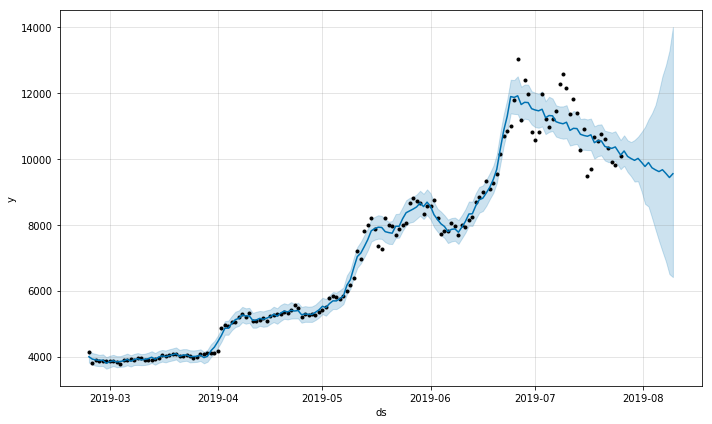

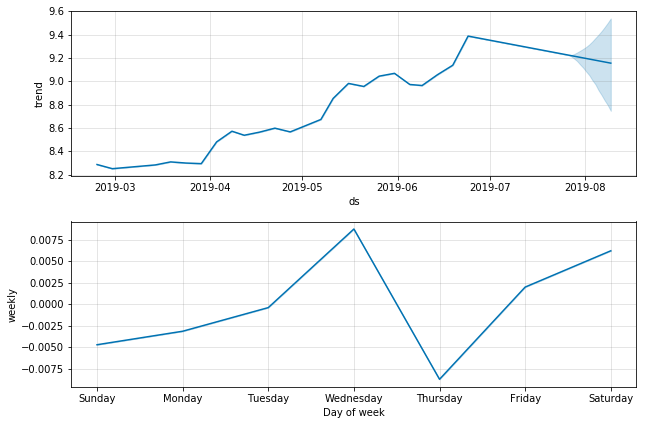

In [97]:
bitcoin_predictor.predict(15)
plt.show()

The forecast for testing period is:

In [98]:
bitcoin_predictor.error_forecast.head()

,ds,yhat,yhat_upper,yhat_lower
150,2019-07-23,10689.006424,11244.841876,10185.743749
151,2019-07-24,10747.885180,11303.865663,10188.759885
152,2019-07-25,10538.308360,11101.488093,9963.788877


The actual value(s) for testing period is:

In [99]:
bitcoin_predictor.test['y'] = bitcoin_predictor.test['y'].apply(lambda x: np.e**x)
bitcoin_predictor.test.head()

,ds,y
2,2019-07-23 00:00:00,9900.770000
1,2019-07-24 00:00:00,9811.930000
0,2019-07-25 12:38:25,10089.030612


The forecast for the next 15 days is:

In [100]:
bitcoin_predictor.forecast[['ds', 'yhat']].tail(15)

,ds,yhat
153,2019-07-26 12:38:25,10239.261215
154,2019-07-27 12:38:25,10074.712437
155,2019-07-28 12:38:25,10009.152356
156,2019-07-29 12:38:25,9954.478726
157,2019-07-30 12:38:25,10014.017267
158,2019-07-31 12:38:25,9895.847783
159,2019-08-01 12:38:25,9768.589233
160,2019-08-02 12:38:25,9888.227104
161,2019-08-03 12:38:25,9729.319575
162,2019-08-04 12:38:25,9666.007100


As you can see, we can closely predict the closing prices for the next week based on a training period representative of the current price volatility.

# Appendix

## Blockchain Tecnology

A Blockchain is essentially a distributed database of records or public ledger of all transactions or digital events that have been executed and shared among participating parties. Each transaction in the public ledger is verified by consensus of a majority of the participants in the system. Once entered information can never be erased. The Blockchain contains a certain and verifiable record of every single transaction ever made.

Blockchain technology itself has worked flawlessly over the years and is being successfully applied to both financial and non-financial world applications.

## The basic components of the Blockchain

**Node**: they are the participants of the Blockchain and are physically constituted by the servers of each participant.

**Transaction**: the data that represent the values object of "exchange" and that need to be verified, approved and then archived.

**Block**: is represented by the grouping of a set of transactions that are merged to be verified, approved and then archived by the participants of the Blockchain.

**Ledger**: is the public register in which all the transactions carried out in an orderly and sequential manner are "annotated" with maximum transparency and in an immutable manner. The Ledger is made up of the set of blocks that are chained to each other through an encryption function and thanks to the use of hash.

**Hash**: is an operation (Non-Invertable) that allows you to map a text and/or numeric string of variable length into a unique string of a given length. The Hash uniquely and securely identifies each block. A hash must not be used to trace the text that generated it.

Each block therefore contains several transactions and has a hash located in the header. The Hash records all information related to the block and a Hash with information about the previous block allows you to create the chain and tie a block to the other.

The Blockchain is organized to update itself automatically on each of the clients participating in the network. Each operation performed must be automatically confirmed by all the individual nodes through cryptographic software, which checks a data set defined by private key or seed, which is used to sign the transactions, guaranteeing the digital identity of those who authorized them.

## How Blockchain works

1. A node starts a transaction by first creating and then digitally signing it with its private key (created via cryptography) . A transaction can represent various actions in a Blockchain, most commonly this is a data structure that represents transfer of value between users on the Blockchain network. Transaction data structure usually consists of some logic of transfer of value, relevant rules, source and destination addresses, and other validation information.

2. A transaction is propagated by using a flooding protocol called "Gossip" to peers that validate the transaction based on preset criteria. Usually, more than one node are required to verify the transaction.

3. Once the transaction is validated it is included in a block which is then propagated onto the network. At this point, the transaction is considered confirmed.

4. The newly-created block now becomes part of the ledger, and the next block links itself cryptographically back to this block. This link is a hash pointer. At this stage the transaction gets its second confirmation and the block gets its first confirmation.

5. Transactions are then reconfirmed every time a new block is created. Usually six confirmations in the a network are required to consider the transaction final.

<img src="blockchain.jpg" title="How does Blockchain work" />
<figcaption><center>Figure 5 : How Blockchain works</center></figcaption>

## Characteristics of a Blockchain

Understanding how a Blockchain works from a technical point of view is valuable only to the extent of developing or troubleshooting one. In order cohesively grasp the potential unto apply Blockchain technology, you must also understand the characteristics of a Blockchain. It is important to note that not all characteristics listed below will apply to all Blockchains.

**CONSENSUS**

Probably the most important characteristic of Blockchain is consensus. Blockchain consensus refers to the ability of all anonymous network participants agreeing network’s rules are followed and there is only one truth in the Blockchain environment. Consensus can be achieved in many different ways such as Proof of Work (PoW) algorithm or Proof of Stake (PoS) algorithm.

**DISTRIBUTED COMPUTATION**

The impact capability of the Blockchain network is largely attributed to its distributed architecture. Continuing with the Bitcoin Blockchain example, each user that is running a full node on their computer will have download a full copy of the whole Blockchain. Each full copy will include data for all transactions recorded on the Bitcoin Blockchain. After the copy has been downloaded the node can then run-independently to process transactions and propagate them further across the network. Nodes can also contribute to network-consensus via mining by including transaction data in a block and then finding a proof-of-work for the block. An important concept about Blockchain’s distributed network is that there is no central node processing and distributing the data, but every node can run independently and broadcast any work that is proved.

**INFORMATION STORAGE**

In the case of the Bitcoin Blockchain, information stored within the blocks is btransactional data. However, this feature extends further beyond just cryptocurrency transactions, and can extend into smart contracts, as used on the Ethereum Blockchain.

**PROVENANCE**

In traditional banking, you know your money is in the bank because the bank tells you it is. In a Blockchain transaction, each activity is tracked, recorded, and fully traceable without a third-party required to attest to a specific action.

**IMMUTABILITY**

No participant in the Blockchain network can modify a transaction after it has been recorded. In case of error you cannot edit or undo it, the erroneous record cannot be erased and is always be visible once recorded. To correct the error a new transaction must be generated which will reference the erroneous record.

**ACCESS CONTROL**

In a shared open public ledger such as the Bitcoin Blockchain everyone has access to view and append to the Blockchain. Conversely, a Blockchain can be more privatized and have stricter access to who has permissions to view and edit the Blockchain. These types of privatized chains are typically found in private enterprise blockchains, where data tends to be more sensitive.

## Types of Blockchains

Blockchain is a continually evolving technology. Because of its foundational technology characteristics, new applications are being continuously developed on top of its framework. This means that new there are new sets of requirements to support said innovations. These new requirements mean a specific Blockchain that works for one application, may not work for another. This problem is solved by creating different types of Blockchains.

We explore the three most common types of Blockchain below:

**Public Blockchain**

Also called "permissionless ledgers", contain absolutely no restrictions. Public Blockchains allow anyone to contribute data to the ledger with all participants possessing an identical copy of the ledger. Since there is no single owner of the ledger, this methodology is more suitable for censorship resistant applications (e.g. Bitcoin). Public Blockchains often offer economic incentives for those who secure the network.

**Private Blockchain**

These networks are controlled by either a single or series of designated network administrators. Private Blockchains allow for distributed identical copies of a ledger, but only to a limited amount of trusted participants only. As the network may have an owner(s), this methodology is better suited for applications requiring simplicity, speed, and greater transparency.

**Hybrid Blockchain**

Also called "consortium Blockchains", are considered to be semi-decentralized and employ characteristics of both public and private blockchains. Hybrid Blockchains contain sets of permissions, similar to private blockchains, however, instead of a single organization controlling it, a group of agreed upon organizations control it. Administers of each organization can restrict users’ reading rights as they desire and only allow a limited set of trusted nodes to execute a consensus protocol.

## Bitcoin

Bitcoin is a digital currency created in January 2009. It follows the ideas set out in a white paper by the mysterious Satoshi Nakamoto, whose true identity has yet to be verified. Bitcoin offers the promise of lower transaction fees than traditional online payment mechanisms and is operated by a decentralized authority unlike government-issued currencies.

The first exchange rate was 5 October 2009 and set the value of $ 1 to 1309 BTC.

Bitcoin first reached $ 1,000 on November 27th, 2013.

There are no physical Bitcoins, only balances kept on a public ledger in the cloud that, along with all Bitcoin transactions, is verified by a massive amount of computing power.

Balances are kept using public and private "keys" which are long strings of numbers and letters linked through the mathematical encryption algorithm that was used to create them. The public key (comparable to a bank account number) serves as the address which is published to the world and to which others may send Bitcoins. The private key (comparable to an ATM PIN) is meant to be a guarded secret and only used to authorize Bitcoin transmissions.

## How Bitcoin Works

Bitcoin is one of the first digital currencies to use peer-to-peer technology to facilitate instant payments. The independent individuals and companies who own the governing computing power and participate in the Bitcoin network, also known as "miners," are motivated by rewards (the release of new Bitcoin) and transaction fees paid in Bitcoin. These miners can be thought of as the decentralized authority enforcing the credibility of the Bitcoin network. New Bitcoin is being released to the miners at a fixed, but periodically declining rate, such that the total supply of Bitcoins approaches 21 million. One Bitcoin is divisible to eight decimal places (100 millionths of one Bitcoin) and this smallest unit is referred to as a Satoshi. If necessary, and if the participating miners accept the change, Bitcoin could eventually be made divisible to even more decimal places.

Bitcoin mining is the process through which Bitcoins are released to come into circulation. Basically it involves solving a computationally difficult puzzle to discover a new block which is added to the blockchain and receiving a reward in the form of a few Bitcoins. The block reward was 50 new Bitcoins in 2009 it decreases every four years. As more and more Bitcoins are created, the difficulty of the mining process – that is, the amount of computing power involved – increases.

<img src="history_price.jpg" title="History Price of Bitcoin" />
<figcaption><center>Figure 6 : History Price of Bitcoin</center></figcaption>

## What factors affect the price of Bitcoin?

There are several factors that can influence the price of Bitcoin more or less profoundly:

**Market demand and supply** - This is undoubtedly the most important factor. To date, Bitcoin does not have a physical equivalent in the real world, and can therefore only be sold using networked Exchange services. One of the fundamental principles of the economy explains that the more a currency is purchased the more its value increases, and vice versa it is lowered when it is sold: the Bitcoin is no exception, so much that in the last months of 2013 the price of the currency multiplied by over ten times due to high demand from China.

**Bitcoin and coin holders** - There are currently around 16 million Bitcoins in the world and, although new ones are being generated every day, the maximum number of Bitcoins is around 21 million: since the currency has a maximum unit cost, the price in the future is set to increase.

**News disclosed by the media** - The human factor should never be underestimated, and how people react to news. We recall for example the sharp reduction in the price following the arrest of Ross Ulbricht or the record figures reached shortly before the decision of the SEC on ETFs.

**Technical problems** - The code behind Bitcoin is totally open source, and can therefore be examined by anyone. Updates aimed at fixing bugs or strengthening some weak areas of the code can drive up prices. Conversely, account hacking or DDoS attacks on major companies can make it crash.

**World political and economic events** - In a globalized world like ours, the decisions of a single country can affect the entire planet: it was the case of Japan which began accepting payments starting from the first half of 2017 in Bitcoin.

**Strong instability** - In the world of finance, the term "volatility" means the degree of change in prices over a certain limited period of time. The value of a highly volatile security may increase or decrease from one moment to another, moving along a very wide price scale: the result of the investment is therefore uncertain and potentially risky.